# ImageNet Vision Model Comparison
## Comparative Analysis of ViT, Swin Transformer, and ConvNeXt

**Student:** Satyam Dulal  
**ID:** 23048597  
**Module:** CU6051NI Artificial Intelligence  
**GitHub:** https://github.com/sat-yam-ln2/imagenet-vision-model-comparison

## 1. Environment Setup and Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import os
from IPython.display import Image, display, HTML
import json
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# CUDA optimizations for faster training
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Enable cuDNN auto-tuner for optimal convolution algorithms
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    
    # Enable TF32 for Ampere GPUs (faster matrix operations)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    print(" CUDA optimizations enabled (cudnn.benchmark, TF32)")

# Enable mixed precision training
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()
print("Mixed precision training (AMP) enabled")

c:\Users\satyam\.conda\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Ti
Memory Available: 12.88 GB
 CUDA optimizations enabled (cudnn.benchmark, TF32)
Mixed precision training (AMP) enabled


## 2. Configuration and Hyperparameters

In [2]:
class Config:
    """Configuration class for experimental setup"""
    
    # Dataset paths
    TRAIN_DIR = './dataset/imagenet-mini/train'
    VAL_DIR = './dataset/imagenet-mini/val'

    # Model configurations
    MODELS = {
        'vit': 'vit_base_patch16_224',
        'swin': 'swin_base_patch4_window7_224',
        'convnext': 'convnext_base'
    }
    
    # Training configurations - OPTIMIZED FOR SPEED
    BATCH_SIZE = 64  # Increased batch size for better GPU utilization
    NUM_WORKERS = 8  # Increased workers for faster data loading
    PREFETCH_FACTOR = 4  # Prefetch batches per worker
    IMG_SIZE = 224
    NUM_CLASSES = 1000
    
    # Data fractions for few-shot learning
    DATA_FRACTIONS = [0.01, 0.05, 0.10]  # 1%, 5%, 10%
    
    # Training parameters
    MAX_EPOCHS = 50
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-4
    ACCURACY_THRESHOLD = 0.70  # For convergence speed measurement
    
    # Gradient accumulation (effective batch = BATCH_SIZE * GRAD_ACCUM_STEPS)
    GRAD_ACCUM_STEPS = 1  # Increase if OOM errors occur
    
    # Results directory
    RESULTS_DIR = Path('./results')
    RESULTS_DIR.mkdir(exist_ok=True)
    
    # Visualization settings
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")

config = Config()
print("Configuration loaded successfully!")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Num workers: {config.NUM_WORKERS}")
print(f"  Prefetch factor: {config.PREFETCH_FACTOR}")

Configuration loaded successfully!
  Batch size: 64
  Num workers: 8
  Prefetch factor: 4


## 3. Data Loading and Preprocessing

In [ ]:
def get_data_transforms():
    """
    Define data augmentation and normalization transforms
    Simpler augmentation to avoid overfitting on small data
    """
    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(config.IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(config.IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform


def create_subset_dataset(dataset, fraction):
    """
    Create stratified subset maintaining class balance
    """
    # Get class indices
    class_to_indices = {}
    for idx, (_, label) in enumerate(dataset.imgs):
        if label not in class_to_indices:
            class_to_indices[label] = []
        class_to_indices[label].append(idx)
    
    # Sample from each class
    subset_indices = []
    for class_label, indices in class_to_indices.items():
        n_samples = max(1, int(len(indices) * fraction))
        sampled = np.random.choice(indices, n_samples, replace=False)
        subset_indices.extend(sampled)
    
    np.random.shuffle(subset_indices)
    return Subset(dataset, subset_indices)


def load_datasets(data_fraction=1.0):
    """
    Load ImageNet training and validation datasets
    OPTIMIZED: persistent_workers, prefetch_factor, pin_memory
    
    Args:
        data_fraction: Fraction of training data to use
    
    Returns:
        train_loader, val_loader, dataset_sizes
    """
    train_transform, val_transform = get_data_transforms()
    
    # Load full datasets
    print(f"Loading datasets with {data_fraction*100}% training data...")
    
    try:
        train_dataset = ImageFolder(config.TRAIN_DIR, transform=train_transform)
        val_dataset = ImageFolder(config.VAL_DIR, transform=val_transform)
    except FileNotFoundError:
        print("ERROR: Dataset not found!")
        print(f"Please ensure ImageNet data is at:")
        print(f"  Training: {config.TRAIN_DIR}")
        print(f"  Validation: {config.VAL_DIR}")
        return None, None, None
    
    # Create subset if needed
    if data_fraction < 1.0:
        train_dataset = create_subset_dataset(train_dataset, data_fraction)
    
    # Create OPTIMIZED data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True,  # Fast CPU to GPU transfer
        prefetch_factor=config.PREFETCH_FACTOR,  # Prefetch batches
        persistent_workers=True,  # Keep workers alive between epochs
        drop_last=True  # Avoid small final batch issues
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE * 2,  # Larger batch for validation (no gradients)
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
        prefetch_factor=config.PREFETCH_FACTOR,
        persistent_workers=True
    )
    
    dataset_sizes = {
        'train': len(train_dataset),
        'val': len(val_dataset)
    }
    
    print(f"✓ Training samples: {dataset_sizes['train']}")
    print(f"✓ Validation samples: {dataset_sizes['val']}")
    print(f"✓ Training batches: {len(train_loader)}")
    print(f"✓ DataLoader optimized with {config.NUM_WORKERS} workers, prefetch={config.PREFETCH_FACTOR}")
    
    return train_loader, val_loader, dataset_sizes


## 4. Model Architecture Setup

In [ ]:
def create_model(model_name, pretrained=True):
    """
    Create and initialize vision model
    
    Args:
        model_name: Name of the model ('vit', 'swin', 'convnext')
        pretrained: Whether to use pretrained weights
    
    Returns:
        model: Initialized model
    """
    model_key = config.MODELS[model_name]
    
    print(f"\nInitializing {model_name.upper()} model...")
    print(f"Architecture: {model_key}")
    
    # Create model using timm library
    model = timm.create_model(
        model_key,
        pretrained=pretrained,
        num_classes=config.NUM_CLASSES
    )
    
    # Move to device
    model = model.to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    return model


def get_model_summary(model, model_name):
    """Generate model summary statistics"""
    total_params = sum(p.numel() for p in model.parameters())
    
    summary = {
        'model': model_name,
        'total_parameters': total_params,
        'size_mb': total_params * 4 / (1024 ** 2)  # Assuming float32
    }
    
    return summary


## 5. Training Functions

In [5]:
class MetricsTracker:
    """Track training and validation metrics"""
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.train_losses = []
        self.val_losses = []
        self.train_top1_accs = []
        self.train_top5_accs = []
        self.val_top1_accs = []
        self.val_top5_accs = []
        self.convergence_epoch = None
    
    def update(self, train_loss, val_loss, train_top1, train_top5, val_top1, val_top5):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_top1_accs.append(train_top1)
        self.train_top5_accs.append(train_top5)
        self.val_top1_accs.append(val_top1)
        self.val_top5_accs.append(val_top5)


def calculate_accuracy(outputs, targets, topk=(1, 5)):
    """
    Calculate Top-K accuracy
    
    Args:
        outputs: Model predictions (logits)
        targets: Ground truth labels
        topk: Tuple of k values
    
    Returns:
        List of top-k accuracies
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = targets.size(0)
        
        # Get top-k predictions
        _, pred = outputs.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(targets.view(1, -1).expand_as(pred))
        
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        
        return res


def train_one_epoch(model, train_loader, criterion, optimizer, epoch):
    """
    Train model for one epoch - OPTIMIZED WITH AMP
    Uses mixed precision training for 2-3x speedup
    
    Returns:
        avg_loss, top1_acc, top5_acc
    """
    model.train()
    running_loss = 0.0
    top1_correct = 0
    top5_correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    
    for batch_idx, (inputs, targets) in enumerate(pbar):
        # Non-blocking transfer to GPU (overlaps with computation)
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        
        # Mixed precision forward pass
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss = loss / config.GRAD_ACCUM_STEPS  # Scale for gradient accumulation
        
        # Mixed precision backward pass
        scaler.scale(loss).backward()
        
        # Gradient accumulation step
        if (batch_idx + 1) % config.GRAD_ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
        
        # Calculate metrics (unscaled loss)
        running_loss += loss.item() * inputs.size(0) * config.GRAD_ACCUM_STEPS
        top1, top5 = calculate_accuracy(outputs.float(), targets)
        
        batch_size = inputs.size(0)
        top1_correct += top1 * batch_size / 100
        top5_correct += top5 * batch_size / 100
        total += batch_size
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item() * config.GRAD_ACCUM_STEPS:.4f}',
            'top1': f'{top1:.2f}%',
            'top5': f'{top5:.2f}%',
            'gpu_mem': f'{torch.cuda.memory_allocated()/1e9:.1f}GB' if torch.cuda.is_available() else 'N/A'
        })
    
    epoch_loss = running_loss / total
    epoch_top1 = 100 * top1_correct / total
    epoch_top5 = 100 * top5_correct / total
    
    return epoch_loss, epoch_top1, epoch_top5


def validate(model, val_loader, criterion):
    """
    Validate model - OPTIMIZED WITH AMP
    
    Returns:
        avg_loss, top1_acc, top5_acc
    """
    model.eval()
    running_loss = 0.0
    top1_correct = 0
    top5_correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc='Validation'):
            # Non-blocking transfer
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            
            # Mixed precision inference
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            running_loss += loss.item() * inputs.size(0)
            top1, top5 = calculate_accuracy(outputs.float(), targets)
            
            batch_size = inputs.size(0)
            top1_correct += top1 * batch_size / 100
            top5_correct += top5 * batch_size / 100
            total += batch_size
    
    epoch_loss = running_loss / total
    epoch_top1 = 100 * top1_correct / total
    epoch_top5 = 100 * top5_correct / total
    
    return epoch_loss, epoch_top1, epoch_top5

## 6. Complete Training Pipeline

In [6]:
def train_model(model, model_name, train_loader, val_loader, data_fraction):
    """
    Complete training pipeline for a model - OPTIMIZED
    Includes error handling and automatic recovery
    
    Args:
        model: Neural network model
        model_name: Name of the model
        train_loader: Training data loader
        val_loader: Validation data loader
        data_fraction: Fraction of training data used
    
    Returns:
        metrics_tracker, best_model_state
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name.upper()} with {data_fraction*100}% data")
    print(f"{'='*60}\n")
    
    # Setup training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config.MAX_EPOCHS
    )
    
    metrics_tracker = MetricsTracker()
    best_val_acc = 0.0
    best_model_state = None
    start_time = time.time()
    
    # Training loop with error handling
    for epoch in range(1, config.MAX_EPOCHS + 1):
        try:
            # Train
            train_loss, train_top1, train_top5 = train_one_epoch(
                model, train_loader, criterion, optimizer, epoch
            )
            
            # Validate
            val_loss, val_top1, val_top5 = validate(model, val_loader, criterion)
            
            # Update scheduler
            scheduler.step()
            
            # Track metrics
            metrics_tracker.update(
                train_loss, val_loss,
                train_top1, train_top5,
                val_top1, val_top5
            )
            
            # Check for convergence
            if val_top1 >= config.ACCURACY_THRESHOLD * 100 and metrics_tracker.convergence_epoch is None:
                metrics_tracker.convergence_epoch = epoch
                print(f"\n✓ Reached {config.ACCURACY_THRESHOLD*100}% accuracy at epoch {epoch}")
            
            # Save best model
            if val_top1 > best_val_acc:
                best_val_acc = val_top1
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            
            # Print epoch summary
            print(f"\nEpoch {epoch}/{config.MAX_EPOCHS}")
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            print(f"Train Top-1: {train_top1:.2f}% | Val Top-1: {val_top1:.2f}%")
            print(f"Train Top-5: {train_top5:.2f}% | Val Top-5: {val_top5:.2f}%")
            print(f"Best Val Top-1: {best_val_acc:.2f}%")
            
            # GPU memory info
            if torch.cuda.is_available():
                print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.2f}GB / {torch.cuda.max_memory_allocated()/1e9:.2f}GB peak")
                
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"\n⚠ GPU OOM at epoch {epoch}. Clearing cache and continuing...")
                torch.cuda.empty_cache()
                continue
            else:
                raise e
        except KeyboardInterrupt:
            print(f"\n⚠ Training interrupted at epoch {epoch}")
            break
    
    training_time = time.time() - start_time
    
    print(f"\n{'='*60}")
    print(f"Training completed in {training_time/60:.2f} minutes")
    print(f"Best validation Top-1 accuracy: {best_val_acc:.2f}%")
    if metrics_tracker.convergence_epoch:
        print(f"Convergence epoch: {metrics_tracker.convergence_epoch}")
    print(f"{'='*60}\n")
    
    return metrics_tracker, best_model_state

## 7. Experiment Orchestration

In [7]:
class ExperimentResults:
    """Store and manage experimental results"""
    
    def __init__(self):
        self.results = {}
    
    def add_result(self, model_name, data_fraction, metrics_tracker, training_time):
        key = f"{model_name}_{int(data_fraction*100)}pct"
        
        self.results[key] = {
            'model': model_name,
            'data_fraction': data_fraction,
            'final_train_top1': metrics_tracker.train_top1_accs[-1],
            'final_train_top5': metrics_tracker.train_top5_accs[-1],
            'final_val_top1': metrics_tracker.val_top1_accs[-1],
            'final_val_top5': metrics_tracker.val_top5_accs[-1],
            'best_val_top1': max(metrics_tracker.val_top1_accs),
            'best_val_top5': max(metrics_tracker.val_top5_accs),
            'final_train_loss': metrics_tracker.train_losses[-1],
            'final_val_loss': metrics_tracker.val_losses[-1],
            'convergence_epoch': metrics_tracker.convergence_epoch,
            'training_time': training_time,
            'metrics': metrics_tracker
        }
    
    def get_summary_df(self):
        """Create summary DataFrame"""
        summary_data = []
        
        for key, result in self.results.items():
            summary_data.append({
                'Model': result['model'].upper(),
                'Data %': f"{int(result['data_fraction']*100)}%",
                'Final Val Top-1': f"{result['final_val_top1']:.2f}%",
                'Final Val Top-5': f"{result['final_val_top5']:.2f}%",
                'Best Val Top-1': f"{result['best_val_top1']:.2f}%",
                'Convergence Epoch': result['convergence_epoch'] if result['convergence_epoch'] else 'N/A',
                'Training Time (min)': f"{result['training_time']/60:.2f}",
                'Data Efficiency': f"{result['best_val_top1'] / (result['data_fraction']*100):.2f}"
            })
        
        return pd.DataFrame(summary_data)
    
    def save_results(self):
        """Save results to disk"""
        # Save summary table
        df = self.get_summary_df()
        df.to_csv(config.RESULTS_DIR / 'summary_results.csv', index=False)
        
        # Save detailed metrics
        with open(config.RESULTS_DIR / 'detailed_results.json', 'w') as f:
            serializable_results = {}
            for key, result in self.results.items():
                serializable_results[key] = {
                    k: v for k, v in result.items() if k != 'metrics'
                }
            json.dump(serializable_results, f, indent=2)
        
        print(f"\nResults saved to {config.RESULTS_DIR}")


def run_all_experiments():
    """
    Run complete experimental pipeline
    Trains all models on all data fractions
    """
    experiment_results = ExperimentResults()
    
    print("\n" + "="*60)
    print("STARTING COMPLETE EXPERIMENTAL PIPELINE")
    print("="*60)
    
    for model_name in ['vit', 'swin', 'convnext']:
        for data_fraction in config.DATA_FRACTIONS:
            
            print(f"\n{'#'*60}")
            print(f"Model: {model_name.upper()} | Data: {data_fraction*100}%")
            print(f"{'#'*60}")
            
            # Load data
            train_loader, val_loader, dataset_sizes = load_datasets(data_fraction)
            
            if train_loader is None:
                print("Skipping due to data loading error...")
                continue
            
            # Create model
            model = create_model(model_name, pretrained=True)
            
            # Train model
            start_time = time.time()
            metrics_tracker, best_model_state = train_model(
                model, model_name, train_loader, val_loader, data_fraction
            )
            training_time = time.time() - start_time
            
            # Save results
            experiment_results.add_result(
                model_name, data_fraction, metrics_tracker, training_time
            )
            
            # Save model checkpoint
            checkpoint_path = config.RESULTS_DIR / f"{model_name}_{int(data_fraction*100)}pct_best.pth"
            torch.save({
                'model_state_dict': best_model_state,
                'model_name': model_name,
                'data_fraction': data_fraction,
                'metrics': {
                    'val_top1_accs': metrics_tracker.val_top1_accs,
                    'val_top5_accs': metrics_tracker.val_top5_accs
                }
            }, checkpoint_path)
            
            # Clear GPU memory
            del model, train_loader, val_loader
            torch.cuda.empty_cache()
    
    # Save all results
    experiment_results.save_results()
    
    return experiment_results

## 8. Visualization Functions

In [ ]:
def plot_learning_curves(experiment_results):
    """Plot learning curves for all experiments"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Learning Curves: Training and Validation Loss', fontsize=16, fontweight='bold')
    
    for idx, model_name in enumerate(['vit', 'swin', 'convnext']):
        for data_fraction in config.DATA_FRACTIONS:
            key = f"{model_name}_{int(data_fraction*100)}pct"
            
            if key in experiment_results.results:
                metrics = experiment_results.results[key]['metrics']
                
                # Plot training loss
                axes[0, idx].plot(
                    metrics.train_losses,
                    label=f"{int(data_fraction*100)}% data",
                    linewidth=2
                )
                
                # Plot validation loss
                axes[1, idx].plot(
                    metrics.val_losses,
                    label=f"{int(data_fraction*100)}% data",
                    linewidth=2
                )
        
        axes[0, idx].set_title(f'{model_name.upper()} - Training Loss', fontweight='bold')
        axes[0, idx].set_xlabel('Epoch')
        axes[0, idx].set_ylabel('Loss')
        axes[0, idx].legend()
        axes[0, idx].grid(True, alpha=0.3)
        
        axes[1, idx].set_title(f'{model_name.upper()} - Validation Loss', fontweight='bold')
        axes[1, idx].set_xlabel('Epoch')
        axes[1, idx].set_ylabel('Loss')
        axes[1, idx].legend()
        axes[1, idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()


def plot_accuracy_curves(experiment_results):
    """Plot accuracy curves for all experiments"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Accuracy Curves: Top-1 and Top-5 Validation Accuracy', fontsize=16, fontweight='bold')
    
    for idx, model_name in enumerate(['vit', 'swin', 'convnext']):
        for data_fraction in config.DATA_FRACTIONS:
            key = f"{model_name}_{int(data_fraction*100)}pct"
            
            if key in experiment_results.results:
                metrics = experiment_results.results[key]['metrics']
                
                # Plot Top-1 accuracy
                axes[0, idx].plot(
                    metrics.val_top1_accs,
                    label=f"{int(data_fraction*100)}% data",
                    linewidth=2
                )
                
                # Plot Top-5 accuracy
                axes[1, idx].plot(
                    metrics.val_top5_accs,
                    label=f"{int(data_fraction*100)}% data",
                    linewidth=2
                )
        
        axes[0, idx].set_title(f'{model_name.upper()} - Top-1 Accuracy', fontweight='bold')
        axes[0, idx].set_xlabel('Epoch')
        axes[0, idx].set_ylabel('Accuracy (%)')
        axes[0, idx].legend()
        axes[0, idx].grid(True, alpha=0.3)
        axes[0, idx].axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Target')
        
        axes[1, idx].set_title(f'{model_name.upper()} - Top-5 Accuracy', fontweight='bold')
        axes[1, idx].set_xlabel('Epoch')
        axes[1, idx].set_ylabel('Accuracy (%)')
        axes[1, idx].legend()
        axes[1, idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'accuracy_curves.png', dpi=300, bbox_inches='tight')
    plt.show()


def plot_comparative_analysis(experiment_results):
    """Create comparative bar charts"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comparative Analysis Across Models and Data Fractions', 
                 fontsize=16, fontweight='bold')
    
    # Prepare data
    models = []
    data_pcts = []
    top1_accs = []
    top5_accs = []
    conv_epochs = []
    train_times = []
    
    for key, result in experiment_results.results.items():
        models.append(result['model'].upper())
        data_pcts.append(f"{int(result['data_fraction']*100)}%")
        top1_accs.append(result['best_val_top1'])
        top5_accs.append(result['best_val_top5'])
        conv_epochs.append(result['convergence_epoch'] if result['convergence_epoch'] else config.MAX_EPOCHS)
        train_times.append(result['training_time'] / 60)
    
    x_labels = [f"{m}\n{d}" for m, d in zip(models, data_pcts)]
    x_pos = np.arange(len(x_labels))
    
    # Plot 1: Top-1 Accuracy
    axes[0, 0].bar(x_pos, top1_accs, color=sns.color_palette("husl", len(x_pos)))
    axes[0, 0].set_title('Best Validation Top-1 Accuracy', fontweight='bold')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(x_labels, rotation=45, ha='right')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Top-5 Accuracy
    axes[0, 1].bar(x_pos, top5_accs, color=sns.color_palette("husl", len(x_pos)))
    axes[0, 1].set_title('Best Validation Top-5 Accuracy', fontweight='bold')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(x_labels, rotation=45, ha='right')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Convergence Speed
    axes[1, 0].bar(x_pos, conv_epochs, color=sns.color_palette("husl", len(x_pos)))
    axes[1, 0].set_title('Convergence Speed (Epochs to 70% Accuracy)', fontweight='bold')
    axes[1, 0].set_ylabel('Epochs')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(x_labels, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Training Time
    axes[1, 1].bar(x_pos, train_times, color=sns.color_palette("husl", len(x_pos)))
    axes[1, 1].set_title('Total Training Time', fontweight='bold')
    axes[1, 1].set_ylabel('Time (minutes)')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(x_labels, rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'comparative_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


def plot_few_shot_performance(experiment_results):
    """Plot few-shot learning performance"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Few-Shot Learning Performance', fontsize=16, fontweight='bold')
    
    for model_name in ['vit', 'swin', 'convnext']:
        fractions = []
        top1_scores = []
        top5_scores = []
        
        for data_fraction in sorted(config.DATA_FRACTIONS):
            key = f"{model_name}_{int(data_fraction*100)}pct"
            
            if key in experiment_results.results:
                fractions.append(data_fraction * 100)
                top1_scores.append(experiment_results.results[key]['best_val_top1'])
                top5_scores.append(experiment_results.results[key]['best_val_top5'])
        
        # Plot Top-1
        axes[0].plot(fractions, top1_scores, marker='o', linewidth=2, 
                    markersize=8, label=model_name.upper())
        
        # Plot Top-5
        axes[1].plot(fractions, top5_scores, marker='o', linewidth=2, 
                    markersize=8, label=model_name.upper())
    
    axes[0].set_title('Top-1 Accuracy vs Data Fraction', fontweight='bold')
    axes[0].set_xlabel('Training Data (%)')
    axes[0].set_ylabel('Best Validation Accuracy (%)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_title('Top-5 Accuracy vs Data Fraction', fontweight='bold')
    axes[1].set_xlabel('Training Data (%)')
    axes[1].set_ylabel('Best Validation Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'few_shot_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_convergence_comparison(experiment_results):
    """Plot convergence speed - KEY PROPOSAL METRIC"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    models = []
    data_pcts = []
    conv_epochs = []
    
    for key, result in sorted(experiment_results.results.items()):
        models.append(result['model'].upper())
        data_pcts.append(f"{int(result['data_fraction']*100)}%")
        
        if result['convergence_epoch']:
            conv_epochs.append(result['convergence_epoch'])
        else:
            conv_epochs.append(config.MAX_EPOCHS)
    
    x_labels = [f"{m}\n{d}" for m, d in zip(models, data_pcts)]
    x_pos = np.arange(len(x_labels))
    
    ax.bar(x_pos, conv_epochs)
    ax.set_title('Convergence Speed (Epochs to 70% Accuracy)')
    ax.set_ylabel('Epochs')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'convergence_speed.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_few_shot_performance(experiment_results):
    """Plot few-shot learning performance - PROPOSAL REQUIREMENT"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Few-Shot Learning Performance', fontsize=16, fontweight='bold')
    
    for model_name in ['vit', 'swin', 'convnext']:
        fractions = []
        top1_scores = []
        top5_scores = []
        
        for data_fraction in sorted(config.DATA_FRACTIONS):
            key = f"{model_name}_{int(data_fraction*100)}pct"
            
            if key in experiment_results.results:
                fractions.append(data_fraction * 100)
                top1_scores.append(experiment_results.results[key]['best_val_top1'])
                top5_scores.append(experiment_results.results[key]['best_val_top5'])
        
        # Plot Top-1
        axes[0].plot(fractions, top1_scores, marker='o', linewidth=2, 
                    markersize=8, label=model_name.upper())
        
        # Plot Top-5
        axes[1].plot(fractions, top5_scores, marker='o', linewidth=2, 
                    markersize=8, label=model_name.upper())
    
    axes[0].set_title('Top-1 Accuracy vs Data Fraction', fontweight='bold')
    axes[0].set_xlabel('Training Data (%)')
    axes[0].set_ylabel('Best Validation Accuracy (%)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_title('Top-5 Accuracy vs Data Fraction', fontweight='bold')
    axes[1].set_xlabel('Training Data (%)')
    axes[1].set_ylabel('Best Validation Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(config.RESULTS_DIR / 'few_shot_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

def generate_all_visualizations(experiment_results):
    """Generate all visualization plots"""
    print("\n" + "="*60)
    print("GENERATING VISUALIZATIONS")
    print("="*60 + "\n")
    
    plot_learning_curves(experiment_results)
    print("✓ Learning curves saved")
    
    plot_accuracy_curves(experiment_results)
    print("✓ Accuracy curves saved")
    
    plot_comparative_analysis(experiment_results)
    print("✓ Comparative analysis saved")
    
    plot_few_shot_performance(experiment_results)
    print("✓ Few-shot performance saved")

    plot_convergence_comparison(experiment_results)
    print("✓ Convergence speed saved") 

    print(f"\nAll visualizations saved to {config.RESULTS_DIR}")

## 9. Main Execution Pipeline

In [9]:
def main():
    """
    Main execution function
    Orchestrates the complete experimental pipeline
    """
    print("\n" + "="*60)
    print("IMAGENET VISION MODEL COMPARISON")
    print("Comparative Analysis of ViT, Swin Transformer, and ConvNeXt")
    print("="*60)
    print(f"\nStudent: Satyam Dulal")
    print(f"ID: 23048597")
    print(f"Module: CU6051NI Artificial Intelligence")
    print("="*60 + "\n")
    
    # Run all experiments
    experiment_results = run_all_experiments()
    
    # Generate visualizations
    generate_all_visualizations(experiment_results)
    
    # Display summary
    print("\n" + "="*60)
    print("EXPERIMENTAL RESULTS SUMMARY")
    print("="*60 + "\n")
    
    summary_df = experiment_results.get_summary_df()
    print(summary_df.to_string(index=False))
    
    print("\n" + "="*60)
    print("EXPERIMENT COMPLETED SUCCESSFULLY")
    print("="*60)
    
    return experiment_results

## 10. Quick Test Mode (for debugging)

In [10]:
def quick_test():
    """
    Quick test with minimal epochs for debugging
    Use this to verify everything works before full training
    """
    print("\n" + "="*60)
    print("RUNNING QUICK TEST MODE")
    print("="*60 + "\n")
    
    # Temporarily reduce epochs
    original_epochs = config.MAX_EPOCHS
    config.MAX_EPOCHS = 3
    
    # Test with smallest data fraction
    test_fraction = 0.01
    
    # Load data
    train_loader, val_loader, dataset_sizes = load_datasets(test_fraction)
    
    if train_loader is None:
        print("Cannot run test - data not available")
        config.MAX_EPOCHS = original_epochs
        return
    
    # Test one model
    model = create_model('vit', pretrained=True)
    
    start_time = time.time()
    metrics_tracker, best_model_state = train_model(
        model, 'vit', train_loader, val_loader, test_fraction
    )
    test_time = time.time() - start_time
    
    print(f"\n✓ Quick test completed in {test_time/60:.2f} minutes")
    print(f"✓ Final validation Top-1: {metrics_tracker.val_top1_accs[-1]:.2f}%")
    print(f"✓ Final validation Top-5: {metrics_tracker.val_top5_accs[-1]:.2f}%")
    
    # Restore original epochs
    config.MAX_EPOCHS = original_epochs
    
    # Cleanup
    del model, train_loader, val_loader
    torch.cuda.empty_cache()
    
    print("\n✓ System verification successful!")
    print("Ready to run full experiments with main()")

## 11. Run Experiments


IMAGENET VISION MODEL COMPARISON
Comparative Analysis of ViT, Swin Transformer, and ConvNeXt

Student: Satyam Dulal
ID: 23048597
Module: CU6051NI Artificial Intelligence


STARTING COMPLETE EXPERIMENTAL PIPELINE

############################################################
Model: VIT | Data: 1.0%
############################################################
Loading datasets with 1.0% training data...
✓ Training samples: 1000
✓ Validation samples: 3923
✓ Training batches: 15
✓ DataLoader optimized with 8 workers, prefetch=4

Initializing VIT model...
Architecture: vit_base_patch16_224
Total parameters: 86,567,656
Trainable parameters: 86,567,656

Training VIT with 1.0% data



Validation: 100%|██████████| 31/31 [00:20<00:00,  1.54it/s]



✓ Reached 70.0% accuracy at epoch 1

Epoch 1/50
Train Loss: 0.6901 | Val Loss: 1.0163
Train Top-1: 82.40% | Val Top-1: 74.82%
Train Top-5: 96.15% | Val Top-5: 92.94%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.51it/s]



Epoch 2/50
Train Loss: 0.2914 | Val Loss: 1.0785
Train Top-1: 91.88% | Val Top-1: 73.80%
Train Top-5: 98.85% | Val Top-5: 92.86%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]



Epoch 3/50
Train Loss: 0.0951 | Val Loss: 1.2309
Train Top-1: 97.50% | Val Top-1: 71.91%
Train Top-5: 99.79% | Val Top-5: 91.97%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.88it/s]



Epoch 4/50
Train Loss: 0.0429 | Val Loss: 1.2825
Train Top-1: 99.17% | Val Top-1: 71.37%
Train Top-5: 99.79% | Val Top-5: 91.72%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 5/50
Train Loss: 0.0264 | Val Loss: 1.2443
Train Top-1: 99.48% | Val Top-1: 72.90%
Train Top-5: 99.90% | Val Top-5: 92.63%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.31it/s]



Epoch 6/50
Train Loss: 0.0126 | Val Loss: 1.3042
Train Top-1: 99.48% | Val Top-1: 72.52%
Train Top-5: 100.00% | Val Top-5: 91.61%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 7/50
Train Loss: 0.0147 | Val Loss: 1.4493
Train Top-1: 99.48% | Val Top-1: 69.87%
Train Top-5: 99.90% | Val Top-5: 90.98%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.33it/s]



Epoch 8/50
Train Loss: 0.0234 | Val Loss: 1.4447
Train Top-1: 99.27% | Val Top-1: 69.77%
Train Top-5: 100.00% | Val Top-5: 90.14%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.33it/s]



Epoch 9/50
Train Loss: 0.0259 | Val Loss: 1.4708
Train Top-1: 99.38% | Val Top-1: 69.72%
Train Top-5: 99.90% | Val Top-5: 89.68%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.30it/s]



Epoch 10/50
Train Loss: 0.0570 | Val Loss: 1.4231
Train Top-1: 99.06% | Val Top-1: 69.36%
Train Top-5: 99.79% | Val Top-5: 89.85%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.31it/s]



Epoch 11/50
Train Loss: 0.0448 | Val Loss: 1.3967
Train Top-1: 98.96% | Val Top-1: 69.59%
Train Top-5: 99.90% | Val Top-5: 90.16%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.30it/s]



Epoch 12/50
Train Loss: 0.0242 | Val Loss: 1.4358
Train Top-1: 99.38% | Val Top-1: 69.64%
Train Top-5: 100.00% | Val Top-5: 89.88%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.30it/s]



Epoch 13/50
Train Loss: 0.0149 | Val Loss: 1.4586
Train Top-1: 99.48% | Val Top-1: 69.36%
Train Top-5: 100.00% | Val Top-5: 90.19%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.33it/s]



Epoch 14/50
Train Loss: 0.0238 | Val Loss: 1.4849
Train Top-1: 99.69% | Val Top-1: 68.98%
Train Top-5: 99.79% | Val Top-5: 89.83%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.29it/s]



Epoch 15/50
Train Loss: 0.0178 | Val Loss: 1.4899
Train Top-1: 99.38% | Val Top-1: 69.59%
Train Top-5: 100.00% | Val Top-5: 89.88%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 16/50
Train Loss: 0.0077 | Val Loss: 1.6642
Train Top-1: 99.90% | Val Top-1: 66.17%
Train Top-5: 100.00% | Val Top-5: 88.07%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.39it/s]



Epoch 17/50
Train Loss: 0.0143 | Val Loss: 1.5570
Train Top-1: 99.69% | Val Top-1: 68.26%
Train Top-5: 99.90% | Val Top-5: 89.24%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.33it/s]



Epoch 18/50
Train Loss: 0.0291 | Val Loss: 1.5603
Train Top-1: 99.27% | Val Top-1: 67.88%
Train Top-5: 99.79% | Val Top-5: 89.01%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.39it/s]



Epoch 19/50
Train Loss: 0.0074 | Val Loss: 1.5986
Train Top-1: 99.79% | Val Top-1: 67.50%
Train Top-5: 100.00% | Val Top-5: 89.04%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.36it/s]



Epoch 20/50
Train Loss: 0.0083 | Val Loss: 1.4829
Train Top-1: 99.79% | Val Top-1: 69.72%
Train Top-5: 100.00% | Val Top-5: 90.01%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.37it/s]



Epoch 21/50
Train Loss: 0.0035 | Val Loss: 1.4699
Train Top-1: 99.90% | Val Top-1: 69.72%
Train Top-5: 100.00% | Val Top-5: 90.14%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.36it/s]



Epoch 22/50
Train Loss: 0.0013 | Val Loss: 1.4570
Train Top-1: 100.00% | Val Top-1: 70.25%
Train Top-5: 100.00% | Val Top-5: 90.06%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.36it/s]



Epoch 23/50
Train Loss: 0.0009 | Val Loss: 1.4373
Train Top-1: 100.00% | Val Top-1: 70.66%
Train Top-5: 100.00% | Val Top-5: 90.21%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.36it/s]



Epoch 24/50
Train Loss: 0.0020 | Val Loss: 1.4224
Train Top-1: 99.90% | Val Top-1: 71.17%
Train Top-5: 100.00% | Val Top-5: 90.54%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.36it/s]



Epoch 25/50
Train Loss: 0.0017 | Val Loss: 1.4145
Train Top-1: 99.90% | Val Top-1: 70.94%
Train Top-5: 100.00% | Val Top-5: 90.49%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.33it/s]



Epoch 26/50
Train Loss: 0.0007 | Val Loss: 1.4105
Train Top-1: 100.00% | Val Top-1: 71.14%
Train Top-5: 100.00% | Val Top-5: 90.64%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.32it/s]



Epoch 27/50
Train Loss: 0.0005 | Val Loss: 1.4086
Train Top-1: 100.00% | Val Top-1: 70.94%
Train Top-5: 100.00% | Val Top-5: 90.75%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.32it/s]



Epoch 28/50
Train Loss: 0.0005 | Val Loss: 1.4054
Train Top-1: 100.00% | Val Top-1: 71.07%
Train Top-5: 100.00% | Val Top-5: 90.72%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 29/50
Train Loss: 0.0004 | Val Loss: 1.4029
Train Top-1: 100.00% | Val Top-1: 71.14%
Train Top-5: 100.00% | Val Top-5: 90.70%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 30/50
Train Loss: 0.0008 | Val Loss: 1.4004
Train Top-1: 100.00% | Val Top-1: 71.09%
Train Top-5: 100.00% | Val Top-5: 90.77%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.33it/s]



Epoch 31/50
Train Loss: 0.0008 | Val Loss: 1.3967
Train Top-1: 100.00% | Val Top-1: 71.48%
Train Top-5: 100.00% | Val Top-5: 90.80%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.29it/s]



Epoch 32/50
Train Loss: 0.0004 | Val Loss: 1.3955
Train Top-1: 100.00% | Val Top-1: 71.45%
Train Top-5: 100.00% | Val Top-5: 90.87%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.33it/s]



Epoch 33/50
Train Loss: 0.0003 | Val Loss: 1.3943
Train Top-1: 100.00% | Val Top-1: 71.55%
Train Top-5: 100.00% | Val Top-5: 90.87%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.29it/s]



Epoch 34/50
Train Loss: 0.0003 | Val Loss: 1.3933
Train Top-1: 100.00% | Val Top-1: 71.55%
Train Top-5: 100.00% | Val Top-5: 90.95%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.29it/s]



Epoch 35/50
Train Loss: 0.0003 | Val Loss: 1.3926
Train Top-1: 100.00% | Val Top-1: 71.58%
Train Top-5: 100.00% | Val Top-5: 90.95%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.34it/s]



Epoch 36/50
Train Loss: 0.0003 | Val Loss: 1.3915
Train Top-1: 100.00% | Val Top-1: 71.63%
Train Top-5: 100.00% | Val Top-5: 90.95%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.31it/s]



Epoch 37/50
Train Loss: 0.0003 | Val Loss: 1.3909
Train Top-1: 100.00% | Val Top-1: 71.58%
Train Top-5: 100.00% | Val Top-5: 90.95%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.36it/s]



Epoch 38/50
Train Loss: 0.0003 | Val Loss: 1.3902
Train Top-1: 100.00% | Val Top-1: 71.63%
Train Top-5: 100.00% | Val Top-5: 90.95%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.34it/s]



Epoch 39/50
Train Loss: 0.0036 | Val Loss: 1.3877
Train Top-1: 99.90% | Val Top-1: 71.63%
Train Top-5: 99.90% | Val Top-5: 90.98%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.32it/s]



Epoch 40/50
Train Loss: 0.0003 | Val Loss: 1.3872
Train Top-1: 100.00% | Val Top-1: 71.71%
Train Top-5: 100.00% | Val Top-5: 90.95%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.34it/s]



Epoch 41/50
Train Loss: 0.0003 | Val Loss: 1.3869
Train Top-1: 100.00% | Val Top-1: 71.71%
Train Top-5: 100.00% | Val Top-5: 90.98%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.32it/s]



Epoch 42/50
Train Loss: 0.0002 | Val Loss: 1.3867
Train Top-1: 100.00% | Val Top-1: 71.71%
Train Top-5: 100.00% | Val Top-5: 90.98%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.37it/s]



Epoch 43/50
Train Loss: 0.0003 | Val Loss: 1.3867
Train Top-1: 100.00% | Val Top-1: 71.73%
Train Top-5: 100.00% | Val Top-5: 90.98%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.34it/s]



Epoch 44/50
Train Loss: 0.0003 | Val Loss: 1.3865
Train Top-1: 100.00% | Val Top-1: 71.71%
Train Top-5: 100.00% | Val Top-5: 91.00%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.89it/s]



Epoch 45/50
Train Loss: 0.0002 | Val Loss: 1.3865
Train Top-1: 100.00% | Val Top-1: 71.68%
Train Top-5: 100.00% | Val Top-5: 91.00%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.06it/s]



Epoch 46/50
Train Loss: 0.0002 | Val Loss: 1.3864
Train Top-1: 100.00% | Val Top-1: 71.68%
Train Top-5: 100.00% | Val Top-5: 91.00%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.96it/s]



Epoch 47/50
Train Loss: 0.0003 | Val Loss: 1.3863
Train Top-1: 100.00% | Val Top-1: 71.68%
Train Top-5: 100.00% | Val Top-5: 91.00%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]



Epoch 48/50
Train Loss: 0.0002 | Val Loss: 1.3864
Train Top-1: 100.00% | Val Top-1: 71.71%
Train Top-5: 100.00% | Val Top-5: 91.00%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]



Epoch 49/50
Train Loss: 0.0002 | Val Loss: 1.3863
Train Top-1: 100.00% | Val Top-1: 71.68%
Train Top-5: 100.00% | Val Top-5: 91.00%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]



Epoch 50/50
Train Loss: 0.0002 | Val Loss: 1.3863
Train Top-1: 100.00% | Val Top-1: 71.71%
Train Top-5: 100.00% | Val Top-5: 91.00%
Best Val Top-1: 74.82%
GPU Memory: 1.06GB / 5.69GB peak

Training completed in 9.55 minutes
Best validation Top-1 accuracy: 74.82%
Convergence epoch: 1


############################################################
Model: VIT | Data: 5.0%
############################################################
Loading datasets with 5.0% training data...
✓ Training samples: 1291
✓ Validation samples: 3923
✓ Training batches: 20
✓ DataLoader optimized with 8 workers, prefetch=4

Initializing VIT model...
Architecture: vit_base_patch16_224
Total parameters: 86,567,656
Trainable parameters: 86,567,656

Training VIT with 5.0% data



Validation: 100%|██████████| 31/31 [00:21<00:00,  1.44it/s]



✓ Reached 70.0% accuracy at epoch 1

Epoch 1/50
Train Loss: 0.7845 | Val Loss: 0.9556
Train Top-1: 79.45% | Val Top-1: 75.58%
Train Top-5: 95.39% | Val Top-5: 94.01%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.16it/s]



Epoch 2/50
Train Loss: 0.2169 | Val Loss: 1.1701
Train Top-1: 94.06% | Val Top-1: 73.41%
Train Top-5: 99.22% | Val Top-5: 91.84%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.16it/s]



Epoch 3/50
Train Loss: 0.0711 | Val Loss: 1.2219
Train Top-1: 98.67% | Val Top-1: 72.90%
Train Top-5: 99.84% | Val Top-5: 91.89%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]



Epoch 4/50
Train Loss: 0.0659 | Val Loss: 1.1890
Train Top-1: 98.28% | Val Top-1: 73.85%
Train Top-5: 99.77% | Val Top-5: 92.48%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]



Epoch 5/50
Train Loss: 0.0243 | Val Loss: 1.2647
Train Top-1: 99.45% | Val Top-1: 72.34%
Train Top-5: 100.00% | Val Top-5: 91.94%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.89it/s]



Epoch 6/50
Train Loss: 0.0214 | Val Loss: 1.2876
Train Top-1: 99.61% | Val Top-1: 71.91%
Train Top-5: 99.84% | Val Top-5: 91.87%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]



Epoch 7/50
Train Loss: 0.0136 | Val Loss: 1.2870
Train Top-1: 99.92% | Val Top-1: 72.37%
Train Top-5: 100.00% | Val Top-5: 91.92%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]



Epoch 8/50
Train Loss: 0.0158 | Val Loss: 1.3761
Train Top-1: 99.84% | Val Top-1: 71.12%
Train Top-5: 100.00% | Val Top-5: 91.38%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.05it/s]



Epoch 9/50
Train Loss: 0.0366 | Val Loss: 1.5510
Train Top-1: 98.91% | Val Top-1: 68.16%
Train Top-5: 99.92% | Val Top-5: 88.94%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.02it/s]



Epoch 10/50
Train Loss: 0.0724 | Val Loss: 1.5942
Train Top-1: 97.97% | Val Top-1: 67.02%
Train Top-5: 99.77% | Val Top-5: 88.58%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]



Epoch 11/50
Train Loss: 0.0558 | Val Loss: 1.5873
Train Top-1: 98.83% | Val Top-1: 67.12%
Train Top-5: 99.84% | Val Top-5: 89.80%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]



Epoch 12/50
Train Loss: 0.0405 | Val Loss: 1.5561
Train Top-1: 99.06% | Val Top-1: 67.50%
Train Top-5: 99.92% | Val Top-5: 89.60%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]



Epoch 13/50
Train Loss: 0.0183 | Val Loss: 1.6341
Train Top-1: 99.53% | Val Top-1: 67.09%
Train Top-5: 100.00% | Val Top-5: 88.58%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.87it/s]



Epoch 14/50
Train Loss: 0.0268 | Val Loss: 1.7630
Train Top-1: 99.38% | Val Top-1: 65.26%
Train Top-5: 100.00% | Val Top-5: 88.02%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]



Epoch 15/50
Train Loss: 0.0290 | Val Loss: 1.6378
Train Top-1: 99.22% | Val Top-1: 67.47%
Train Top-5: 99.92% | Val Top-5: 88.58%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.98it/s]



Epoch 16/50
Train Loss: 0.0305 | Val Loss: 1.6403
Train Top-1: 99.30% | Val Top-1: 66.66%
Train Top-5: 99.92% | Val Top-5: 88.55%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]



Epoch 17/50
Train Loss: 0.0275 | Val Loss: 1.6297
Train Top-1: 99.61% | Val Top-1: 66.35%
Train Top-5: 99.84% | Val Top-5: 88.02%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.01it/s]



Epoch 18/50
Train Loss: 0.0115 | Val Loss: 1.6315
Train Top-1: 99.69% | Val Top-1: 66.56%
Train Top-5: 100.00% | Val Top-5: 89.01%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.06it/s]



Epoch 19/50
Train Loss: 0.0075 | Val Loss: 1.6026
Train Top-1: 99.77% | Val Top-1: 67.22%
Train Top-5: 100.00% | Val Top-5: 89.40%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.15it/s]



Epoch 20/50
Train Loss: 0.0122 | Val Loss: 1.6012
Train Top-1: 99.77% | Val Top-1: 67.40%
Train Top-5: 99.84% | Val Top-5: 89.47%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.84it/s]



Epoch 21/50
Train Loss: 0.0025 | Val Loss: 1.6396
Train Top-1: 100.00% | Val Top-1: 66.25%
Train Top-5: 100.00% | Val Top-5: 88.99%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.05it/s]



Epoch 22/50
Train Loss: 0.0030 | Val Loss: 1.5992
Train Top-1: 99.84% | Val Top-1: 67.17%
Train Top-5: 100.00% | Val Top-5: 89.55%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]



Epoch 23/50
Train Loss: 0.0027 | Val Loss: 1.5595
Train Top-1: 100.00% | Val Top-1: 68.06%
Train Top-5: 100.00% | Val Top-5: 89.85%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]



Epoch 24/50
Train Loss: 0.0036 | Val Loss: 1.5406
Train Top-1: 99.92% | Val Top-1: 68.44%
Train Top-5: 100.00% | Val Top-5: 90.19%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.01it/s]



Epoch 25/50
Train Loss: 0.0011 | Val Loss: 1.5808
Train Top-1: 100.00% | Val Top-1: 67.88%
Train Top-5: 100.00% | Val Top-5: 89.91%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]



Epoch 26/50
Train Loss: 0.0041 | Val Loss: 1.5333
Train Top-1: 99.92% | Val Top-1: 68.42%
Train Top-5: 99.92% | Val Top-5: 90.01%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.13it/s]



Epoch 27/50
Train Loss: 0.0007 | Val Loss: 1.5310
Train Top-1: 100.00% | Val Top-1: 68.85%
Train Top-5: 100.00% | Val Top-5: 89.93%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]



Epoch 28/50
Train Loss: 0.0006 | Val Loss: 1.5230
Train Top-1: 100.00% | Val Top-1: 68.88%
Train Top-5: 100.00% | Val Top-5: 90.08%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.96it/s]



Epoch 29/50
Train Loss: 0.0007 | Val Loss: 1.5132
Train Top-1: 100.00% | Val Top-1: 69.13%
Train Top-5: 100.00% | Val Top-5: 90.36%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.84it/s]



Epoch 30/50
Train Loss: 0.0004 | Val Loss: 1.5087
Train Top-1: 100.00% | Val Top-1: 69.39%
Train Top-5: 100.00% | Val Top-5: 90.47%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.05it/s]



Epoch 31/50
Train Loss: 0.0004 | Val Loss: 1.5052
Train Top-1: 100.00% | Val Top-1: 69.36%
Train Top-5: 100.00% | Val Top-5: 90.49%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]



Epoch 32/50
Train Loss: 0.0009 | Val Loss: 1.5054
Train Top-1: 100.00% | Val Top-1: 69.41%
Train Top-5: 100.00% | Val Top-5: 90.44%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]



Epoch 33/50
Train Loss: 0.0003 | Val Loss: 1.5078
Train Top-1: 100.00% | Val Top-1: 69.39%
Train Top-5: 100.00% | Val Top-5: 90.39%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]



Epoch 34/50
Train Loss: 0.0003 | Val Loss: 1.5066
Train Top-1: 100.00% | Val Top-1: 69.39%
Train Top-5: 100.00% | Val Top-5: 90.44%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.02it/s]



Epoch 35/50
Train Loss: 0.0003 | Val Loss: 1.5050
Train Top-1: 100.00% | Val Top-1: 69.46%
Train Top-5: 100.00% | Val Top-5: 90.44%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.88it/s]



Epoch 36/50
Train Loss: 0.0003 | Val Loss: 1.5036
Train Top-1: 100.00% | Val Top-1: 69.44%
Train Top-5: 100.00% | Val Top-5: 90.47%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.15it/s]



Epoch 37/50
Train Loss: 0.0003 | Val Loss: 1.5020
Train Top-1: 100.00% | Val Top-1: 69.54%
Train Top-5: 100.00% | Val Top-5: 90.52%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.98it/s]



Epoch 38/50
Train Loss: 0.0003 | Val Loss: 1.5011
Train Top-1: 100.00% | Val Top-1: 69.51%
Train Top-5: 100.00% | Val Top-5: 90.57%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.09it/s]



Epoch 39/50
Train Loss: 0.0003 | Val Loss: 1.5004
Train Top-1: 100.00% | Val Top-1: 69.51%
Train Top-5: 100.00% | Val Top-5: 90.57%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.13it/s]



Epoch 40/50
Train Loss: 0.0005 | Val Loss: 1.4999
Train Top-1: 100.00% | Val Top-1: 69.51%
Train Top-5: 100.00% | Val Top-5: 90.57%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]



Epoch 41/50
Train Loss: 0.0003 | Val Loss: 1.4999
Train Top-1: 100.00% | Val Top-1: 69.51%
Train Top-5: 100.00% | Val Top-5: 90.57%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]



Epoch 42/50
Train Loss: 0.0003 | Val Loss: 1.4992
Train Top-1: 100.00% | Val Top-1: 69.54%
Train Top-5: 100.00% | Val Top-5: 90.57%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.08it/s]



Epoch 43/50
Train Loss: 0.0002 | Val Loss: 1.4989
Train Top-1: 100.00% | Val Top-1: 69.49%
Train Top-5: 100.00% | Val Top-5: 90.57%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.00it/s]



Epoch 44/50
Train Loss: 0.0003 | Val Loss: 1.4986
Train Top-1: 100.00% | Val Top-1: 69.49%
Train Top-5: 100.00% | Val Top-5: 90.62%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]



Epoch 45/50
Train Loss: 0.0002 | Val Loss: 1.4983
Train Top-1: 100.00% | Val Top-1: 69.51%
Train Top-5: 100.00% | Val Top-5: 90.62%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.88it/s]



Epoch 46/50
Train Loss: 0.0005 | Val Loss: 1.4979
Train Top-1: 100.00% | Val Top-1: 69.46%
Train Top-5: 100.00% | Val Top-5: 90.64%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]



Epoch 47/50
Train Loss: 0.0002 | Val Loss: 1.4978
Train Top-1: 100.00% | Val Top-1: 69.49%
Train Top-5: 100.00% | Val Top-5: 90.64%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]



Epoch 48/50
Train Loss: 0.0003 | Val Loss: 1.4978
Train Top-1: 100.00% | Val Top-1: 69.49%
Train Top-5: 100.00% | Val Top-5: 90.67%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]



Epoch 49/50
Train Loss: 0.0002 | Val Loss: 1.4977
Train Top-1: 100.00% | Val Top-1: 69.49%
Train Top-5: 100.00% | Val Top-5: 90.67%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]



Epoch 50/50
Train Loss: 0.0003 | Val Loss: 1.4977
Train Top-1: 100.00% | Val Top-1: 69.49%
Train Top-5: 100.00% | Val Top-5: 90.64%
Best Val Top-1: 75.58%
GPU Memory: 1.06GB / 5.69GB peak

Training completed in 9.62 minutes
Best validation Top-1 accuracy: 75.58%
Convergence epoch: 1


############################################################
Model: VIT | Data: 10.0%
############################################################
Loading datasets with 10.0% training data...
✓ Training samples: 3013
✓ Validation samples: 3923
✓ Training batches: 47
✓ DataLoader optimized with 8 workers, prefetch=4

Initializing VIT model...
Architecture: vit_base_patch16_224
Total parameters: 86,567,656
Trainable parameters: 86,567,656

Training VIT with 10.0% data



Validation: 100%|██████████| 31/31 [00:21<00:00,  1.44it/s]



✓ Reached 70.0% accuracy at epoch 1

Epoch 1/50
Train Loss: 0.7203 | Val Loss: 1.0577
Train Top-1: 80.12% | Val Top-1: 73.62%
Train Top-5: 95.84% | Val Top-5: 92.45%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.05it/s]



Epoch 2/50
Train Loss: 0.2222 | Val Loss: 1.1499
Train Top-1: 93.92% | Val Top-1: 73.21%
Train Top-5: 99.40% | Val Top-5: 92.23%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.07it/s]



Epoch 3/50
Train Loss: 0.1108 | Val Loss: 1.3508
Train Top-1: 97.07% | Val Top-1: 69.82%
Train Top-5: 99.73% | Val Top-5: 90.54%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.10it/s]



Epoch 4/50
Train Loss: 0.0760 | Val Loss: 1.3821
Train Top-1: 97.87% | Val Top-1: 70.66%
Train Top-5: 99.80% | Val Top-5: 90.67%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.02it/s]



Epoch 5/50
Train Loss: 0.0616 | Val Loss: 1.3760
Train Top-1: 98.54% | Val Top-1: 71.20%
Train Top-5: 99.83% | Val Top-5: 91.26%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.96it/s]



Epoch 6/50
Train Loss: 0.0632 | Val Loss: 1.4462
Train Top-1: 98.04% | Val Top-1: 70.43%
Train Top-5: 99.97% | Val Top-5: 90.16%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.97it/s]



Epoch 7/50
Train Loss: 0.0563 | Val Loss: 1.6061
Train Top-1: 98.77% | Val Top-1: 67.22%
Train Top-5: 99.87% | Val Top-5: 87.92%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.03it/s]



Epoch 8/50
Train Loss: 0.0673 | Val Loss: 1.5103
Train Top-1: 98.17% | Val Top-1: 68.90%
Train Top-5: 99.87% | Val Top-5: 88.89%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]



Epoch 9/50
Train Loss: 0.0736 | Val Loss: 1.6863
Train Top-1: 98.27% | Val Top-1: 66.45%
Train Top-5: 99.83% | Val Top-5: 87.71%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.09it/s]



Epoch 10/50
Train Loss: 0.0833 | Val Loss: 1.6708
Train Top-1: 97.91% | Val Top-1: 65.84%
Train Top-5: 99.83% | Val Top-5: 87.28%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.96it/s]



Epoch 11/50
Train Loss: 0.0692 | Val Loss: 1.7396
Train Top-1: 98.20% | Val Top-1: 64.44%
Train Top-5: 99.87% | Val Top-5: 86.95%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.11it/s]



Epoch 12/50
Train Loss: 0.0360 | Val Loss: 1.6704
Train Top-1: 99.14% | Val Top-1: 66.89%
Train Top-5: 99.90% | Val Top-5: 87.15%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.13it/s]



Epoch 13/50
Train Loss: 0.0333 | Val Loss: 1.7145
Train Top-1: 99.17% | Val Top-1: 65.23%
Train Top-5: 99.93% | Val Top-5: 86.69%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]



Epoch 14/50
Train Loss: 0.0264 | Val Loss: 1.6121
Train Top-1: 99.40% | Val Top-1: 67.98%
Train Top-5: 99.97% | Val Top-5: 88.27%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]



Epoch 15/50
Train Loss: 0.0089 | Val Loss: 1.6225
Train Top-1: 99.73% | Val Top-1: 67.42%
Train Top-5: 100.00% | Val Top-5: 88.71%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.95it/s]



Epoch 16/50
Train Loss: 0.0081 | Val Loss: 1.6404
Train Top-1: 99.90% | Val Top-1: 67.12%
Train Top-5: 100.00% | Val Top-5: 88.02%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.93it/s]



Epoch 17/50
Train Loss: 0.0021 | Val Loss: 1.6077
Train Top-1: 100.00% | Val Top-1: 68.29%
Train Top-5: 100.00% | Val Top-5: 88.94%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.92it/s]



Epoch 18/50
Train Loss: 0.0015 | Val Loss: 1.5585
Train Top-1: 100.00% | Val Top-1: 69.18%
Train Top-5: 100.00% | Val Top-5: 89.50%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.14it/s]



Epoch 19/50
Train Loss: 0.0009 | Val Loss: 1.5516
Train Top-1: 100.00% | Val Top-1: 68.82%
Train Top-5: 100.00% | Val Top-5: 89.52%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.09it/s]



Epoch 20/50
Train Loss: 0.0007 | Val Loss: 1.5464
Train Top-1: 100.00% | Val Top-1: 69.31%
Train Top-5: 100.00% | Val Top-5: 89.57%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.02it/s]



Epoch 21/50
Train Loss: 0.0007 | Val Loss: 1.5348
Train Top-1: 100.00% | Val Top-1: 69.72%
Train Top-5: 100.00% | Val Top-5: 89.83%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  5.10it/s]



Epoch 22/50
Train Loss: 0.0009 | Val Loss: 1.5209
Train Top-1: 100.00% | Val Top-1: 69.87%
Train Top-5: 100.00% | Val Top-5: 90.06%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.79it/s]



Epoch 23/50
Train Loss: 0.0029 | Val Loss: 1.6150
Train Top-1: 99.97% | Val Top-1: 68.06%
Train Top-5: 99.97% | Val Top-5: 88.78%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.86it/s]



Epoch 24/50
Train Loss: 0.0007 | Val Loss: 1.5668
Train Top-1: 100.00% | Val Top-1: 68.82%
Train Top-5: 100.00% | Val Top-5: 89.24%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:06<00:00,  4.89it/s]



Epoch 25/50
Train Loss: 0.0007 | Val Loss: 1.5435
Train Top-1: 100.00% | Val Top-1: 69.18%
Train Top-5: 100.00% | Val Top-5: 89.65%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.44it/s]



Epoch 26/50
Train Loss: 0.0007 | Val Loss: 1.5480
Train Top-1: 100.00% | Val Top-1: 69.59%
Train Top-5: 100.00% | Val Top-5: 89.91%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.44it/s]



Epoch 27/50
Train Loss: 0.0011 | Val Loss: 1.5332
Train Top-1: 99.97% | Val Top-1: 69.90%
Train Top-5: 100.00% | Val Top-5: 90.24%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.61it/s]



Epoch 28/50
Train Loss: 0.0004 | Val Loss: 1.5215
Train Top-1: 100.00% | Val Top-1: 69.87%
Train Top-5: 100.00% | Val Top-5: 90.21%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.58it/s]



Epoch 29/50
Train Loss: 0.0003 | Val Loss: 1.5181
Train Top-1: 100.00% | Val Top-1: 69.92%
Train Top-5: 100.00% | Val Top-5: 90.31%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.56it/s]



Epoch 30/50
Train Loss: 0.0003 | Val Loss: 1.5177
Train Top-1: 100.00% | Val Top-1: 70.05%
Train Top-5: 100.00% | Val Top-5: 90.31%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.50it/s]



Epoch 31/50
Train Loss: 0.0003 | Val Loss: 1.5165
Train Top-1: 100.00% | Val Top-1: 70.10%
Train Top-5: 100.00% | Val Top-5: 90.39%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.48it/s]



Epoch 32/50
Train Loss: 0.0002 | Val Loss: 1.5153
Train Top-1: 100.00% | Val Top-1: 70.02%
Train Top-5: 100.00% | Val Top-5: 90.42%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.59it/s]



Epoch 33/50
Train Loss: 0.0003 | Val Loss: 1.5146
Train Top-1: 100.00% | Val Top-1: 70.18%
Train Top-5: 100.00% | Val Top-5: 90.49%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.52it/s]



Epoch 34/50
Train Loss: 0.0007 | Val Loss: 1.5215
Train Top-1: 100.00% | Val Top-1: 70.18%
Train Top-5: 100.00% | Val Top-5: 90.34%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.55it/s]



Epoch 35/50
Train Loss: 0.0002 | Val Loss: 1.5219
Train Top-1: 100.00% | Val Top-1: 70.25%
Train Top-5: 100.00% | Val Top-5: 90.54%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.55it/s]



Epoch 36/50
Train Loss: 0.0003 | Val Loss: 1.5205
Train Top-1: 100.00% | Val Top-1: 70.25%
Train Top-5: 100.00% | Val Top-5: 90.54%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.53it/s]



Epoch 37/50
Train Loss: 0.0002 | Val Loss: 1.5192
Train Top-1: 100.00% | Val Top-1: 70.15%
Train Top-5: 100.00% | Val Top-5: 90.52%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.57it/s]



Epoch 38/50
Train Loss: 0.0005 | Val Loss: 1.5156
Train Top-1: 99.97% | Val Top-1: 70.33%
Train Top-5: 100.00% | Val Top-5: 90.70%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.47it/s]



Epoch 39/50
Train Loss: 0.0002 | Val Loss: 1.5146
Train Top-1: 100.00% | Val Top-1: 70.35%
Train Top-5: 100.00% | Val Top-5: 90.75%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.53it/s]



Epoch 40/50
Train Loss: 0.0002 | Val Loss: 1.5142
Train Top-1: 100.00% | Val Top-1: 70.33%
Train Top-5: 100.00% | Val Top-5: 90.75%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.48it/s]



Epoch 41/50
Train Loss: 0.0002 | Val Loss: 1.5128
Train Top-1: 100.00% | Val Top-1: 70.43%
Train Top-5: 100.00% | Val Top-5: 90.75%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.50it/s]



Epoch 42/50
Train Loss: 0.0002 | Val Loss: 1.5123
Train Top-1: 100.00% | Val Top-1: 70.43%
Train Top-5: 100.00% | Val Top-5: 90.72%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.58it/s]



Epoch 43/50
Train Loss: 0.0003 | Val Loss: 1.5118
Train Top-1: 100.00% | Val Top-1: 70.51%
Train Top-5: 100.00% | Val Top-5: 90.67%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.49it/s]



Epoch 44/50
Train Loss: 0.0002 | Val Loss: 1.5117
Train Top-1: 100.00% | Val Top-1: 70.48%
Train Top-5: 100.00% | Val Top-5: 90.67%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.44it/s]



Epoch 45/50
Train Loss: 0.0002 | Val Loss: 1.5115
Train Top-1: 100.00% | Val Top-1: 70.46%
Train Top-5: 100.00% | Val Top-5: 90.67%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.61it/s]



Epoch 46/50
Train Loss: 0.0002 | Val Loss: 1.5114
Train Top-1: 100.00% | Val Top-1: 70.46%
Train Top-5: 100.00% | Val Top-5: 90.64%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.49it/s]



Epoch 47/50
Train Loss: 0.0002 | Val Loss: 1.5113
Train Top-1: 100.00% | Val Top-1: 70.46%
Train Top-5: 100.00% | Val Top-5: 90.64%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.44it/s]



Epoch 48/50
Train Loss: 0.0002 | Val Loss: 1.5112
Train Top-1: 100.00% | Val Top-1: 70.43%
Train Top-5: 100.00% | Val Top-5: 90.64%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.51it/s]



Epoch 49/50
Train Loss: 0.0002 | Val Loss: 1.5112
Train Top-1: 100.00% | Val Top-1: 70.46%
Train Top-5: 100.00% | Val Top-5: 90.64%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.58it/s]



Epoch 50/50
Train Loss: 0.0002 | Val Loss: 1.5112
Train Top-1: 100.00% | Val Top-1: 70.46%
Train Top-5: 100.00% | Val Top-5: 90.64%
Best Val Top-1: 73.62%
GPU Memory: 1.06GB / 5.69GB peak

Training completed in 13.57 minutes
Best validation Top-1 accuracy: 73.62%
Convergence epoch: 1


############################################################
Model: SWIN | Data: 1.0%
############################################################
Loading datasets with 1.0% training data...
✓ Training samples: 1000
✓ Validation samples: 3923
✓ Training batches: 15
✓ DataLoader optimized with 8 workers, prefetch=4

Initializing SWIN model...
Architecture: swin_base_patch4_window7_224
Total parameters: 87,768,224
Trainable parameters: 87,768,224

Training SWIN with 1.0% data



Validation: 100%|██████████| 31/31 [00:26<00:00,  1.17it/s]



✓ Reached 70.0% accuracy at epoch 1

Epoch 1/50
Train Loss: 0.4924 | Val Loss: 0.7316
Train Top-1: 86.67% | Val Top-1: 81.21%
Train Top-5: 97.92% | Val Top-5: 96.35%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:35<00:00,  1.14s/it]



Epoch 2/50
Train Loss: 0.2563 | Val Loss: 0.7538
Train Top-1: 93.33% | Val Top-1: 80.68%
Train Top-5: 99.27% | Val Top-5: 96.35%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:37<00:00,  1.20s/it]



Epoch 3/50
Train Loss: 0.1124 | Val Loss: 0.7959
Train Top-1: 97.08% | Val Top-1: 80.24%
Train Top-5: 99.27% | Val Top-5: 96.15%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:37<00:00,  1.20s/it]



Epoch 4/50
Train Loss: 0.0467 | Val Loss: 0.8648
Train Top-1: 98.85% | Val Top-1: 79.84%
Train Top-5: 99.79% | Val Top-5: 95.74%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:37<00:00,  1.20s/it]



Epoch 5/50
Train Loss: 0.0218 | Val Loss: 0.9038
Train Top-1: 99.38% | Val Top-1: 79.30%
Train Top-5: 100.00% | Val Top-5: 95.44%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:37<00:00,  1.19s/it]



Epoch 6/50
Train Loss: 0.0285 | Val Loss: 0.9343
Train Top-1: 99.58% | Val Top-1: 79.38%
Train Top-5: 100.00% | Val Top-5: 95.62%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:37<00:00,  1.20s/it]



Epoch 7/50
Train Loss: 0.0150 | Val Loss: 0.9773
Train Top-1: 99.58% | Val Top-1: 79.20%
Train Top-5: 100.00% | Val Top-5: 95.54%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:37<00:00,  1.20s/it]



Epoch 8/50
Train Loss: 0.0364 | Val Loss: 1.0007
Train Top-1: 99.58% | Val Top-1: 79.05%
Train Top-5: 99.79% | Val Top-5: 95.00%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:36<00:00,  1.19s/it]



Epoch 9/50
Train Loss: 0.0177 | Val Loss: 1.0182
Train Top-1: 99.58% | Val Top-1: 78.46%
Train Top-5: 100.00% | Val Top-5: 95.21%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:37<00:00,  1.19s/it]



Epoch 10/50
Train Loss: 0.0128 | Val Loss: 1.0669
Train Top-1: 99.69% | Val Top-1: 77.64%
Train Top-5: 100.00% | Val Top-5: 94.54%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:37<00:00,  1.20s/it]



Epoch 11/50
Train Loss: 0.0148 | Val Loss: 1.0775
Train Top-1: 99.58% | Val Top-1: 78.33%
Train Top-5: 100.00% | Val Top-5: 95.08%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:37<00:00,  1.20s/it]



Epoch 12/50
Train Loss: 0.0174 | Val Loss: 1.0974
Train Top-1: 99.38% | Val Top-1: 77.49%
Train Top-5: 100.00% | Val Top-5: 95.08%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:36<00:00,  1.19s/it]



Epoch 13/50
Train Loss: 0.0139 | Val Loss: 1.1022
Train Top-1: 99.79% | Val Top-1: 77.72%
Train Top-5: 100.00% | Val Top-5: 94.88%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:37<00:00,  1.20s/it]



Epoch 14/50
Train Loss: 0.0270 | Val Loss: 1.0930
Train Top-1: 99.27% | Val Top-1: 77.82%
Train Top-5: 100.00% | Val Top-5: 94.95%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:10<00:00,  4.22s/it]



Epoch 15/50
Train Loss: 0.0091 | Val Loss: 1.1030
Train Top-1: 99.79% | Val Top-1: 77.72%
Train Top-5: 100.00% | Val Top-5: 95.00%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:11<00:00,  4.24s/it]



Epoch 16/50
Train Loss: 0.0128 | Val Loss: 1.0898
Train Top-1: 99.69% | Val Top-1: 78.05%
Train Top-5: 100.00% | Val Top-5: 94.85%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:14<00:00,  4.35s/it]



Epoch 17/50
Train Loss: 0.0035 | Val Loss: 1.0865
Train Top-1: 100.00% | Val Top-1: 77.93%
Train Top-5: 100.00% | Val Top-5: 94.77%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:10<00:00,  4.20s/it]



Epoch 18/50
Train Loss: 0.0056 | Val Loss: 1.0805
Train Top-1: 99.90% | Val Top-1: 78.36%
Train Top-5: 100.00% | Val Top-5: 94.98%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:10<00:00,  4.20s/it]



Epoch 19/50
Train Loss: 0.0080 | Val Loss: 1.0856
Train Top-1: 99.90% | Val Top-1: 78.49%
Train Top-5: 100.00% | Val Top-5: 95.03%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:08<00:00,  4.16s/it]



Epoch 20/50
Train Loss: 0.0040 | Val Loss: 1.1149
Train Top-1: 99.90% | Val Top-1: 77.87%
Train Top-5: 100.00% | Val Top-5: 94.98%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:12<00:00,  4.28s/it]



Epoch 21/50
Train Loss: 0.0022 | Val Loss: 1.1063
Train Top-1: 100.00% | Val Top-1: 78.31%
Train Top-5: 100.00% | Val Top-5: 95.05%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:12<00:00,  4.26s/it]



Epoch 22/50
Train Loss: 0.0030 | Val Loss: 1.0941
Train Top-1: 99.90% | Val Top-1: 78.69%
Train Top-5: 100.00% | Val Top-5: 95.05%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:15<00:00,  4.36s/it]



Epoch 23/50
Train Loss: 0.0027 | Val Loss: 1.0953
Train Top-1: 100.00% | Val Top-1: 78.84%
Train Top-5: 100.00% | Val Top-5: 95.03%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:08<00:00,  4.15s/it]



Epoch 24/50
Train Loss: 0.0021 | Val Loss: 1.1089
Train Top-1: 100.00% | Val Top-1: 78.56%
Train Top-5: 100.00% | Val Top-5: 95.18%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:10<00:00,  4.22s/it]



Epoch 25/50
Train Loss: 0.0064 | Val Loss: 1.1039
Train Top-1: 99.79% | Val Top-1: 78.18%
Train Top-5: 100.00% | Val Top-5: 95.26%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:11<00:00,  4.24s/it]



Epoch 26/50
Train Loss: 0.0017 | Val Loss: 1.1165
Train Top-1: 100.00% | Val Top-1: 78.21%
Train Top-5: 100.00% | Val Top-5: 95.26%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:09<00:00,  4.19s/it]



Epoch 27/50
Train Loss: 0.0010 | Val Loss: 1.1221
Train Top-1: 100.00% | Val Top-1: 78.03%
Train Top-5: 100.00% | Val Top-5: 95.31%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:09<00:00,  4.17s/it]



Epoch 28/50
Train Loss: 0.0032 | Val Loss: 1.1180
Train Top-1: 99.90% | Val Top-1: 78.00%
Train Top-5: 100.00% | Val Top-5: 95.21%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:09<00:00,  4.19s/it]



Epoch 29/50
Train Loss: 0.0023 | Val Loss: 1.1248
Train Top-1: 100.00% | Val Top-1: 77.72%
Train Top-5: 100.00% | Val Top-5: 95.11%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:09<00:00,  4.17s/it]



Epoch 30/50
Train Loss: 0.0066 | Val Loss: 1.1254
Train Top-1: 99.90% | Val Top-1: 77.85%
Train Top-5: 100.00% | Val Top-5: 95.13%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:09<00:00,  4.19s/it]



Epoch 31/50
Train Loss: 0.0047 | Val Loss: 1.1384
Train Top-1: 99.90% | Val Top-1: 77.90%
Train Top-5: 100.00% | Val Top-5: 95.26%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:12<00:00,  4.26s/it]



Epoch 32/50
Train Loss: 0.0066 | Val Loss: 1.1238
Train Top-1: 99.90% | Val Top-1: 77.93%
Train Top-5: 100.00% | Val Top-5: 95.28%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:09<00:00,  4.16s/it]



Epoch 33/50
Train Loss: 0.0023 | Val Loss: 1.1212
Train Top-1: 100.00% | Val Top-1: 77.93%
Train Top-5: 100.00% | Val Top-5: 95.18%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:07<00:00,  4.10s/it]



Epoch 34/50
Train Loss: 0.0013 | Val Loss: 1.1238
Train Top-1: 100.00% | Val Top-1: 77.95%
Train Top-5: 100.00% | Val Top-5: 95.21%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:09<00:00,  4.17s/it]



Epoch 35/50
Train Loss: 0.0012 | Val Loss: 1.1223
Train Top-1: 100.00% | Val Top-1: 78.13%
Train Top-5: 100.00% | Val Top-5: 95.26%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:08<00:00,  4.14s/it]



Epoch 36/50
Train Loss: 0.0008 | Val Loss: 1.1225
Train Top-1: 100.00% | Val Top-1: 78.10%
Train Top-5: 100.00% | Val Top-5: 95.28%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:11<00:00,  4.25s/it]



Epoch 37/50
Train Loss: 0.0006 | Val Loss: 1.1235
Train Top-1: 100.00% | Val Top-1: 78.21%
Train Top-5: 100.00% | Val Top-5: 95.26%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:08<00:00,  4.15s/it]



Epoch 38/50
Train Loss: 0.0013 | Val Loss: 1.1232
Train Top-1: 100.00% | Val Top-1: 78.15%
Train Top-5: 100.00% | Val Top-5: 95.28%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:09<00:00,  4.19s/it]



Epoch 39/50
Train Loss: 0.0015 | Val Loss: 1.1239
Train Top-1: 100.00% | Val Top-1: 78.15%
Train Top-5: 100.00% | Val Top-5: 95.26%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:09<00:00,  4.19s/it]



Epoch 40/50
Train Loss: 0.0005 | Val Loss: 1.1241
Train Top-1: 100.00% | Val Top-1: 78.21%
Train Top-5: 100.00% | Val Top-5: 95.26%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:09<00:00,  4.18s/it]



Epoch 41/50
Train Loss: 0.0023 | Val Loss: 1.1237
Train Top-1: 100.00% | Val Top-1: 78.21%
Train Top-5: 100.00% | Val Top-5: 95.31%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:05<00:00,  4.06s/it]



Epoch 42/50
Train Loss: 0.0026 | Val Loss: 1.1222
Train Top-1: 100.00% | Val Top-1: 78.31%
Train Top-5: 100.00% | Val Top-5: 95.36%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:10<00:00,  4.19s/it]



Epoch 43/50
Train Loss: 0.0010 | Val Loss: 1.1217
Train Top-1: 100.00% | Val Top-1: 78.26%
Train Top-5: 100.00% | Val Top-5: 95.34%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:08<00:00,  4.16s/it]



Epoch 44/50
Train Loss: 0.0008 | Val Loss: 1.1211
Train Top-1: 100.00% | Val Top-1: 78.28%
Train Top-5: 100.00% | Val Top-5: 95.36%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:06<00:00,  4.08s/it]



Epoch 45/50
Train Loss: 0.0010 | Val Loss: 1.1212
Train Top-1: 100.00% | Val Top-1: 78.31%
Train Top-5: 100.00% | Val Top-5: 95.31%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:07<00:00,  4.12s/it]



Epoch 46/50
Train Loss: 0.0012 | Val Loss: 1.1214
Train Top-1: 100.00% | Val Top-1: 78.31%
Train Top-5: 100.00% | Val Top-5: 95.28%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:09<00:00,  4.18s/it]



Epoch 47/50
Train Loss: 0.0008 | Val Loss: 1.1214
Train Top-1: 100.00% | Val Top-1: 78.28%
Train Top-5: 100.00% | Val Top-5: 95.31%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:07<00:00,  4.11s/it]



Epoch 48/50
Train Loss: 0.0024 | Val Loss: 1.1216
Train Top-1: 99.90% | Val Top-1: 78.31%
Train Top-5: 100.00% | Val Top-5: 95.31%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:06<00:00,  4.09s/it]



Epoch 49/50
Train Loss: 0.0009 | Val Loss: 1.1216
Train Top-1: 100.00% | Val Top-1: 78.31%
Train Top-5: 100.00% | Val Top-5: 95.31%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [02:09<00:00,  4.18s/it]



Epoch 50/50
Train Loss: 0.0005 | Val Loss: 1.1215
Train Top-1: 100.00% | Val Top-1: 78.28%
Train Top-5: 100.00% | Val Top-5: 95.31%
Best Val Top-1: 81.21%
GPU Memory: 1.09GB / 10.85GB peak

Training completed in 103.20 minutes
Best validation Top-1 accuracy: 81.21%
Convergence epoch: 1


############################################################
Model: SWIN | Data: 5.0%
############################################################
Loading datasets with 5.0% training data...
✓ Training samples: 1291
✓ Validation samples: 3923
✓ Training batches: 20
✓ DataLoader optimized with 8 workers, prefetch=4

Initializing SWIN model...
Architecture: swin_base_patch4_window7_224
Total parameters: 87,768,224
Trainable parameters: 87,768,224

Training SWIN with 5.0% data



Validation: 100%|██████████| 31/31 [01:04<00:00,  2.08s/it]



✓ Reached 70.0% accuracy at epoch 1

Epoch 1/50
Train Loss: 0.4246 | Val Loss: 0.7615
Train Top-1: 88.52% | Val Top-1: 80.98%
Train Top-5: 98.20% | Val Top-5: 96.53%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 2/50
Train Loss: 0.1872 | Val Loss: 0.8315
Train Top-1: 95.47% | Val Top-1: 79.86%
Train Top-5: 99.06% | Val Top-5: 95.77%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 3/50
Train Loss: 0.0693 | Val Loss: 0.8609
Train Top-1: 98.44% | Val Top-1: 80.58%
Train Top-5: 99.77% | Val Top-5: 96.10%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 4/50
Train Loss: 0.0274 | Val Loss: 0.9337
Train Top-1: 99.30% | Val Top-1: 79.56%
Train Top-5: 99.92% | Val Top-5: 95.64%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 5/50
Train Loss: 0.0314 | Val Loss: 0.9890
Train Top-1: 99.45% | Val Top-1: 79.10%
Train Top-5: 99.92% | Val Top-5: 95.28%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:50<00:00,  1.62s/it]



Epoch 6/50
Train Loss: 0.0247 | Val Loss: 0.9513
Train Top-1: 99.45% | Val Top-1: 80.07%
Train Top-5: 100.00% | Val Top-5: 95.69%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:50<00:00,  1.61s/it]



Epoch 7/50
Train Loss: 0.0123 | Val Loss: 0.9718
Train Top-1: 99.61% | Val Top-1: 80.27%
Train Top-5: 100.00% | Val Top-5: 95.64%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 8/50
Train Loss: 0.0103 | Val Loss: 1.0071
Train Top-1: 99.77% | Val Top-1: 80.22%
Train Top-5: 100.00% | Val Top-5: 95.62%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:50<00:00,  1.62s/it]



Epoch 9/50
Train Loss: 0.0160 | Val Loss: 1.0068
Train Top-1: 99.77% | Val Top-1: 80.02%
Train Top-5: 100.00% | Val Top-5: 95.74%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:50<00:00,  1.61s/it]



Epoch 10/50
Train Loss: 0.0073 | Val Loss: 1.0069
Train Top-1: 99.84% | Val Top-1: 80.14%
Train Top-5: 100.00% | Val Top-5: 95.87%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 11/50
Train Loss: 0.0075 | Val Loss: 1.0296
Train Top-1: 99.92% | Val Top-1: 80.14%
Train Top-5: 100.00% | Val Top-5: 95.79%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 12/50
Train Loss: 0.0028 | Val Loss: 1.0381
Train Top-1: 100.00% | Val Top-1: 79.81%
Train Top-5: 100.00% | Val Top-5: 95.59%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 13/50
Train Loss: 0.0022 | Val Loss: 1.0466
Train Top-1: 100.00% | Val Top-1: 79.79%
Train Top-5: 100.00% | Val Top-5: 95.69%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 14/50
Train Loss: 0.0073 | Val Loss: 1.0396
Train Top-1: 99.92% | Val Top-1: 80.04%
Train Top-5: 100.00% | Val Top-5: 95.62%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 15/50
Train Loss: 0.0090 | Val Loss: 1.0276
Train Top-1: 99.84% | Val Top-1: 79.84%
Train Top-5: 100.00% | Val Top-5: 95.39%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 16/50
Train Loss: 0.0023 | Val Loss: 1.0537
Train Top-1: 100.00% | Val Top-1: 79.38%
Train Top-5: 100.00% | Val Top-5: 95.36%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 17/50
Train Loss: 0.0027 | Val Loss: 1.0463
Train Top-1: 100.00% | Val Top-1: 79.81%
Train Top-5: 100.00% | Val Top-5: 95.39%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 18/50
Train Loss: 0.0013 | Val Loss: 1.0566
Train Top-1: 100.00% | Val Top-1: 79.89%
Train Top-5: 100.00% | Val Top-5: 95.28%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 19/50
Train Loss: 0.0049 | Val Loss: 1.0514
Train Top-1: 99.84% | Val Top-1: 79.99%
Train Top-5: 100.00% | Val Top-5: 95.49%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 20/50
Train Loss: 0.0134 | Val Loss: 1.0400
Train Top-1: 99.92% | Val Top-1: 80.07%
Train Top-5: 99.92% | Val Top-5: 95.54%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.60s/it]



Epoch 21/50
Train Loss: 0.0020 | Val Loss: 1.0426
Train Top-1: 100.00% | Val Top-1: 79.96%
Train Top-5: 100.00% | Val Top-5: 95.67%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.60s/it]



Epoch 22/50
Train Loss: 0.0014 | Val Loss: 1.0544
Train Top-1: 100.00% | Val Top-1: 79.94%
Train Top-5: 100.00% | Val Top-5: 95.72%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.60s/it]



Epoch 23/50
Train Loss: 0.0018 | Val Loss: 1.0626
Train Top-1: 100.00% | Val Top-1: 79.99%
Train Top-5: 100.00% | Val Top-5: 95.67%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:50<00:00,  1.62s/it]



Epoch 24/50
Train Loss: 0.0014 | Val Loss: 1.0731
Train Top-1: 100.00% | Val Top-1: 80.02%
Train Top-5: 100.00% | Val Top-5: 95.54%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:50<00:00,  1.61s/it]



Epoch 25/50
Train Loss: 0.0016 | Val Loss: 1.0822
Train Top-1: 100.00% | Val Top-1: 79.89%
Train Top-5: 100.00% | Val Top-5: 95.44%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 26/50
Train Loss: 0.0014 | Val Loss: 1.0935
Train Top-1: 100.00% | Val Top-1: 79.99%
Train Top-5: 100.00% | Val Top-5: 95.39%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 27/50
Train Loss: 0.0011 | Val Loss: 1.0976
Train Top-1: 100.00% | Val Top-1: 79.94%
Train Top-5: 100.00% | Val Top-5: 95.41%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 28/50
Train Loss: 0.0017 | Val Loss: 1.1104
Train Top-1: 99.92% | Val Top-1: 79.48%
Train Top-5: 100.00% | Val Top-5: 95.11%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:50<00:00,  1.61s/it]



Epoch 29/50
Train Loss: 0.0019 | Val Loss: 1.1112
Train Top-1: 100.00% | Val Top-1: 79.53%
Train Top-5: 100.00% | Val Top-5: 95.16%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 30/50
Train Loss: 0.0012 | Val Loss: 1.1039
Train Top-1: 100.00% | Val Top-1: 79.63%
Train Top-5: 100.00% | Val Top-5: 95.31%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:50<00:00,  1.62s/it]



Epoch 31/50
Train Loss: 0.0021 | Val Loss: 1.1029
Train Top-1: 99.92% | Val Top-1: 79.68%
Train Top-5: 100.00% | Val Top-5: 95.46%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:50<00:00,  1.62s/it]



Epoch 32/50
Train Loss: 0.0005 | Val Loss: 1.1070
Train Top-1: 100.00% | Val Top-1: 79.73%
Train Top-5: 100.00% | Val Top-5: 95.44%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.60s/it]



Epoch 33/50
Train Loss: 0.0010 | Val Loss: 1.1040
Train Top-1: 100.00% | Val Top-1: 79.73%
Train Top-5: 100.00% | Val Top-5: 95.39%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 34/50
Train Loss: 0.0030 | Val Loss: 1.0976
Train Top-1: 99.92% | Val Top-1: 79.94%
Train Top-5: 100.00% | Val Top-5: 95.59%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.60s/it]



Epoch 35/50
Train Loss: 0.0040 | Val Loss: 1.0987
Train Top-1: 99.92% | Val Top-1: 80.07%
Train Top-5: 99.92% | Val Top-5: 95.59%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 36/50
Train Loss: 0.0006 | Val Loss: 1.0976
Train Top-1: 100.00% | Val Top-1: 80.07%
Train Top-5: 100.00% | Val Top-5: 95.56%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 37/50
Train Loss: 0.0011 | Val Loss: 1.0974
Train Top-1: 100.00% | Val Top-1: 80.04%
Train Top-5: 100.00% | Val Top-5: 95.56%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 38/50
Train Loss: 0.0014 | Val Loss: 1.1016
Train Top-1: 99.92% | Val Top-1: 80.17%
Train Top-5: 100.00% | Val Top-5: 95.56%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 39/50
Train Loss: 0.0008 | Val Loss: 1.1011
Train Top-1: 100.00% | Val Top-1: 80.04%
Train Top-5: 100.00% | Val Top-5: 95.46%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:50<00:00,  1.61s/it]



Epoch 40/50
Train Loss: 0.0007 | Val Loss: 1.1012
Train Top-1: 100.00% | Val Top-1: 80.07%
Train Top-5: 100.00% | Val Top-5: 95.46%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.60s/it]



Epoch 41/50
Train Loss: 0.0005 | Val Loss: 1.1007
Train Top-1: 100.00% | Val Top-1: 80.14%
Train Top-5: 100.00% | Val Top-5: 95.51%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 42/50
Train Loss: 0.0025 | Val Loss: 1.1015
Train Top-1: 99.92% | Val Top-1: 80.14%
Train Top-5: 100.00% | Val Top-5: 95.51%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:50<00:00,  1.61s/it]



Epoch 43/50
Train Loss: 0.0004 | Val Loss: 1.1029
Train Top-1: 100.00% | Val Top-1: 80.07%
Train Top-5: 100.00% | Val Top-5: 95.49%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 44/50
Train Loss: 0.0004 | Val Loss: 1.1032
Train Top-1: 100.00% | Val Top-1: 80.02%
Train Top-5: 100.00% | Val Top-5: 95.49%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.60s/it]



Epoch 45/50
Train Loss: 0.0005 | Val Loss: 1.1037
Train Top-1: 100.00% | Val Top-1: 79.99%
Train Top-5: 100.00% | Val Top-5: 95.49%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.60s/it]



Epoch 46/50
Train Loss: 0.0003 | Val Loss: 1.1036
Train Top-1: 100.00% | Val Top-1: 79.99%
Train Top-5: 100.00% | Val Top-5: 95.44%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.60s/it]



Epoch 47/50
Train Loss: 0.0004 | Val Loss: 1.1036
Train Top-1: 100.00% | Val Top-1: 79.99%
Train Top-5: 100.00% | Val Top-5: 95.44%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:50<00:00,  1.62s/it]



Epoch 48/50
Train Loss: 0.0005 | Val Loss: 1.1038
Train Top-1: 100.00% | Val Top-1: 80.02%
Train Top-5: 100.00% | Val Top-5: 95.46%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:50<00:00,  1.62s/it]



Epoch 49/50
Train Loss: 0.0017 | Val Loss: 1.1037
Train Top-1: 99.92% | Val Top-1: 80.04%
Train Top-5: 100.00% | Val Top-5: 95.49%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]



Epoch 50/50
Train Loss: 0.0006 | Val Loss: 1.1038
Train Top-1: 100.00% | Val Top-1: 80.04%
Train Top-5: 100.00% | Val Top-5: 95.49%
Best Val Top-1: 80.98%
GPU Memory: 1.09GB / 10.85GB peak

Training completed in 51.83 minutes
Best validation Top-1 accuracy: 80.98%
Convergence epoch: 1


############################################################
Model: SWIN | Data: 10.0%
############################################################
Loading datasets with 10.0% training data...
✓ Training samples: 3013
✓ Validation samples: 3923
✓ Training batches: 47
✓ DataLoader optimized with 8 workers, prefetch=4

Initializing SWIN model...
Architecture: swin_base_patch4_window7_224
Total parameters: 87,768,224
Trainable parameters: 87,768,224

Training SWIN with 10.0% data



Validation: 100%|██████████| 31/31 [00:46<00:00,  1.50s/it]



✓ Reached 70.0% accuracy at epoch 1

Epoch 1/50
Train Loss: 0.4882 | Val Loss: 0.7285
Train Top-1: 85.84% | Val Top-1: 81.26%
Train Top-5: 98.57% | Val Top-5: 96.30%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 2/50
Train Loss: 0.1596 | Val Loss: 0.8354
Train Top-1: 95.21% | Val Top-1: 80.58%
Train Top-5: 99.77% | Val Top-5: 96.00%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 3/50
Train Loss: 0.0701 | Val Loss: 0.9072
Train Top-1: 98.04% | Val Top-1: 80.04%
Train Top-5: 99.90% | Val Top-5: 95.74%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 4/50
Train Loss: 0.0511 | Val Loss: 0.9749
Train Top-1: 98.64% | Val Top-1: 79.63%
Train Top-5: 99.97% | Val Top-5: 95.46%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 5/50
Train Loss: 0.0479 | Val Loss: 1.0410
Train Top-1: 98.70% | Val Top-1: 78.33%
Train Top-5: 99.90% | Val Top-5: 95.16%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 6/50
Train Loss: 0.0439 | Val Loss: 1.1264
Train Top-1: 98.90% | Val Top-1: 78.13%
Train Top-5: 99.90% | Val Top-5: 94.65%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 7/50
Train Loss: 0.0464 | Val Loss: 1.1183
Train Top-1: 98.87% | Val Top-1: 78.00%
Train Top-5: 99.87% | Val Top-5: 94.70%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 8/50
Train Loss: 0.0300 | Val Loss: 1.1417
Train Top-1: 99.14% | Val Top-1: 78.46%
Train Top-5: 99.97% | Val Top-5: 94.88%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 9/50
Train Loss: 0.0310 | Val Loss: 1.1604
Train Top-1: 99.24% | Val Top-1: 76.88%
Train Top-5: 99.97% | Val Top-5: 94.26%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 10/50
Train Loss: 0.0413 | Val Loss: 1.1637
Train Top-1: 98.90% | Val Top-1: 76.88%
Train Top-5: 100.00% | Val Top-5: 94.19%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 11/50
Train Loss: 0.0240 | Val Loss: 1.1893
Train Top-1: 99.47% | Val Top-1: 76.73%
Train Top-5: 99.97% | Val Top-5: 94.60%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 12/50
Train Loss: 0.0325 | Val Loss: 1.1726
Train Top-1: 99.17% | Val Top-1: 76.83%
Train Top-5: 100.00% | Val Top-5: 94.57%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 13/50
Train Loss: 0.0224 | Val Loss: 1.1727
Train Top-1: 99.43% | Val Top-1: 77.72%
Train Top-5: 99.93% | Val Top-5: 94.60%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 14/50
Train Loss: 0.0143 | Val Loss: 1.1745
Train Top-1: 99.63% | Val Top-1: 77.62%
Train Top-5: 100.00% | Val Top-5: 94.57%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]



Epoch 15/50
Train Loss: 0.0108 | Val Loss: 1.1994
Train Top-1: 99.83% | Val Top-1: 76.83%
Train Top-5: 100.00% | Val Top-5: 94.34%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 16/50
Train Loss: 0.0097 | Val Loss: 1.1929
Train Top-1: 99.80% | Val Top-1: 77.54%
Train Top-5: 100.00% | Val Top-5: 94.57%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 17/50
Train Loss: 0.0166 | Val Loss: 1.2555
Train Top-1: 99.60% | Val Top-1: 76.09%
Train Top-5: 100.00% | Val Top-5: 93.83%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 18/50
Train Loss: 0.0142 | Val Loss: 1.2330
Train Top-1: 99.63% | Val Top-1: 76.57%
Train Top-5: 100.00% | Val Top-5: 93.96%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 19/50
Train Loss: 0.0122 | Val Loss: 1.2522
Train Top-1: 99.63% | Val Top-1: 76.65%
Train Top-5: 99.97% | Val Top-5: 94.26%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 20/50
Train Loss: 0.0047 | Val Loss: 1.2683
Train Top-1: 99.87% | Val Top-1: 77.21%
Train Top-5: 100.00% | Val Top-5: 94.24%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 21/50
Train Loss: 0.0059 | Val Loss: 1.2971
Train Top-1: 99.80% | Val Top-1: 76.83%
Train Top-5: 100.00% | Val Top-5: 94.04%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 22/50
Train Loss: 0.0084 | Val Loss: 1.2836
Train Top-1: 99.83% | Val Top-1: 77.08%
Train Top-5: 100.00% | Val Top-5: 94.06%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 23/50
Train Loss: 0.0104 | Val Loss: 1.3120
Train Top-1: 99.77% | Val Top-1: 75.86%
Train Top-5: 100.00% | Val Top-5: 93.86%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 24/50
Train Loss: 0.0063 | Val Loss: 1.3071
Train Top-1: 99.77% | Val Top-1: 76.83%
Train Top-5: 100.00% | Val Top-5: 93.83%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 25/50
Train Loss: 0.0030 | Val Loss: 1.3185
Train Top-1: 99.93% | Val Top-1: 77.11%
Train Top-5: 100.00% | Val Top-5: 93.86%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 26/50
Train Loss: 0.0032 | Val Loss: 1.3008
Train Top-1: 99.97% | Val Top-1: 77.49%
Train Top-5: 100.00% | Val Top-5: 94.01%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 27/50
Train Loss: 0.0063 | Val Loss: 1.2832
Train Top-1: 99.97% | Val Top-1: 76.98%
Train Top-5: 100.00% | Val Top-5: 94.34%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 28/50
Train Loss: 0.0015 | Val Loss: 1.2874
Train Top-1: 99.97% | Val Top-1: 77.03%
Train Top-5: 100.00% | Val Top-5: 94.34%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 29/50
Train Loss: 0.0027 | Val Loss: 1.2965
Train Top-1: 99.93% | Val Top-1: 77.01%
Train Top-5: 100.00% | Val Top-5: 94.57%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 30/50
Train Loss: 0.0012 | Val Loss: 1.2974
Train Top-1: 100.00% | Val Top-1: 77.21%
Train Top-5: 100.00% | Val Top-5: 94.37%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 31/50
Train Loss: 0.0025 | Val Loss: 1.3010
Train Top-1: 99.93% | Val Top-1: 77.29%
Train Top-5: 99.97% | Val Top-5: 94.37%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 32/50
Train Loss: 0.0013 | Val Loss: 1.3019
Train Top-1: 99.97% | Val Top-1: 77.39%
Train Top-5: 100.00% | Val Top-5: 94.39%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 33/50
Train Loss: 0.0036 | Val Loss: 1.3053
Train Top-1: 99.90% | Val Top-1: 77.42%
Train Top-5: 99.97% | Val Top-5: 94.39%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 34/50
Train Loss: 0.0011 | Val Loss: 1.3063
Train Top-1: 100.00% | Val Top-1: 77.34%
Train Top-5: 100.00% | Val Top-5: 94.57%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 35/50
Train Loss: 0.0020 | Val Loss: 1.3073
Train Top-1: 99.93% | Val Top-1: 77.44%
Train Top-5: 100.00% | Val Top-5: 94.47%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 36/50
Train Loss: 0.0009 | Val Loss: 1.3068
Train Top-1: 100.00% | Val Top-1: 77.42%
Train Top-5: 100.00% | Val Top-5: 94.54%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 37/50
Train Loss: 0.0009 | Val Loss: 1.3061
Train Top-1: 100.00% | Val Top-1: 77.44%
Train Top-5: 100.00% | Val Top-5: 94.60%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 38/50
Train Loss: 0.0011 | Val Loss: 1.3067
Train Top-1: 99.97% | Val Top-1: 77.31%
Train Top-5: 100.00% | Val Top-5: 94.52%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 39/50
Train Loss: 0.0007 | Val Loss: 1.3080
Train Top-1: 100.00% | Val Top-1: 77.34%
Train Top-5: 100.00% | Val Top-5: 94.52%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 40/50
Train Loss: 0.0008 | Val Loss: 1.3096
Train Top-1: 100.00% | Val Top-1: 77.39%
Train Top-5: 100.00% | Val Top-5: 94.49%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]



Epoch 41/50
Train Loss: 0.0017 | Val Loss: 1.3091
Train Top-1: 100.00% | Val Top-1: 77.47%
Train Top-5: 100.00% | Val Top-5: 94.62%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 42/50
Train Loss: 0.0012 | Val Loss: 1.3096
Train Top-1: 100.00% | Val Top-1: 77.44%
Train Top-5: 100.00% | Val Top-5: 94.49%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 43/50
Train Loss: 0.0011 | Val Loss: 1.3106
Train Top-1: 100.00% | Val Top-1: 77.52%
Train Top-5: 100.00% | Val Top-5: 94.52%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 44/50
Train Loss: 0.0010 | Val Loss: 1.3106
Train Top-1: 99.97% | Val Top-1: 77.49%
Train Top-5: 100.00% | Val Top-5: 94.49%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 45/50
Train Loss: 0.0009 | Val Loss: 1.3111
Train Top-1: 100.00% | Val Top-1: 77.44%
Train Top-5: 100.00% | Val Top-5: 94.49%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]



Epoch 46/50
Train Loss: 0.0012 | Val Loss: 1.3106
Train Top-1: 99.97% | Val Top-1: 77.49%
Train Top-5: 100.00% | Val Top-5: 94.44%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 47/50
Train Loss: 0.0016 | Val Loss: 1.3104
Train Top-1: 99.97% | Val Top-1: 77.54%
Train Top-5: 100.00% | Val Top-5: 94.49%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 48/50
Train Loss: 0.0027 | Val Loss: 1.3103
Train Top-1: 99.97% | Val Top-1: 77.57%
Train Top-5: 99.97% | Val Top-5: 94.47%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 49/50
Train Loss: 0.0009 | Val Loss: 1.3104
Train Top-1: 100.00% | Val Top-1: 77.57%
Train Top-5: 100.00% | Val Top-5: 94.49%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]



Epoch 50/50
Train Loss: 0.0009 | Val Loss: 1.3105
Train Top-1: 100.00% | Val Top-1: 77.59%
Train Top-5: 100.00% | Val Top-5: 94.49%
Best Val Top-1: 81.26%
GPU Memory: 1.08GB / 10.85GB peak

Training completed in 43.44 minutes
Best validation Top-1 accuracy: 81.26%
Convergence epoch: 1


############################################################
Model: CONVNEXT | Data: 1.0%
############################################################
Loading datasets with 1.0% training data...
✓ Training samples: 1000
✓ Validation samples: 3923
✓ Training batches: 15
✓ DataLoader optimized with 8 workers, prefetch=4

Initializing CONVNEXT model...
Architecture: convnext_base
Total parameters: 88,591,464
Trainable parameters: 88,591,464

Training CONVNEXT with 1.0% data



Validation: 100%|██████████| 31/31 [00:31<00:00,  1.01s/it]



✓ Reached 70.0% accuracy at epoch 1

Epoch 1/50
Train Loss: 0.3409 | Val Loss: 0.6221
Train Top-1: 90.52% | Val Top-1: 83.33%
Train Top-5: 98.75% | Val Top-5: 97.07%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 2/50
Train Loss: 0.1023 | Val Loss: 0.6419
Train Top-1: 97.60% | Val Top-1: 82.84%
Train Top-5: 100.00% | Val Top-5: 96.89%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 3/50
Train Loss: 0.0393 | Val Loss: 0.6480
Train Top-1: 99.69% | Val Top-1: 82.33%
Train Top-5: 99.90% | Val Top-5: 96.81%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 4/50
Train Loss: 0.0202 | Val Loss: 0.6548
Train Top-1: 99.90% | Val Top-1: 82.59%
Train Top-5: 100.00% | Val Top-5: 96.79%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 5/50
Train Loss: 0.0192 | Val Loss: 0.6566
Train Top-1: 99.79% | Val Top-1: 82.46%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 6/50
Train Loss: 0.0148 | Val Loss: 0.6612
Train Top-1: 99.90% | Val Top-1: 82.36%
Train Top-5: 100.00% | Val Top-5: 96.79%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.29it/s]



Epoch 7/50
Train Loss: 0.0114 | Val Loss: 0.6689
Train Top-1: 99.90% | Val Top-1: 82.13%
Train Top-5: 100.00% | Val Top-5: 96.64%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.22it/s]



Epoch 8/50
Train Loss: 0.0076 | Val Loss: 0.6675
Train Top-1: 100.00% | Val Top-1: 82.28%
Train Top-5: 100.00% | Val Top-5: 96.74%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.29it/s]



Epoch 9/50
Train Loss: 0.0105 | Val Loss: 0.6645
Train Top-1: 99.79% | Val Top-1: 82.39%
Train Top-5: 100.00% | Val Top-5: 96.86%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 10/50
Train Loss: 0.0059 | Val Loss: 0.6728
Train Top-1: 100.00% | Val Top-1: 82.18%
Train Top-5: 100.00% | Val Top-5: 96.84%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 11/50
Train Loss: 0.0103 | Val Loss: 0.6722
Train Top-1: 99.90% | Val Top-1: 82.36%
Train Top-5: 99.90% | Val Top-5: 96.81%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.29it/s]



Epoch 12/50
Train Loss: 0.0047 | Val Loss: 0.6720
Train Top-1: 100.00% | Val Top-1: 82.28%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.21it/s]



Epoch 13/50
Train Loss: 0.0040 | Val Loss: 0.6724
Train Top-1: 100.00% | Val Top-1: 82.39%
Train Top-5: 100.00% | Val Top-5: 96.71%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]



Epoch 14/50
Train Loss: 0.0037 | Val Loss: 0.6722
Train Top-1: 100.00% | Val Top-1: 82.49%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 15/50
Train Loss: 0.0033 | Val Loss: 0.6733
Train Top-1: 100.00% | Val Top-1: 82.67%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 16/50
Train Loss: 0.0037 | Val Loss: 0.6737
Train Top-1: 100.00% | Val Top-1: 82.77%
Train Top-5: 100.00% | Val Top-5: 96.71%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.32it/s]



Epoch 17/50
Train Loss: 0.0067 | Val Loss: 0.6781
Train Top-1: 99.90% | Val Top-1: 82.49%
Train Top-5: 100.00% | Val Top-5: 96.66%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.31it/s]



Epoch 18/50
Train Loss: 0.0028 | Val Loss: 0.6834
Train Top-1: 100.00% | Val Top-1: 82.26%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 19/50
Train Loss: 0.0027 | Val Loss: 0.6834
Train Top-1: 100.00% | Val Top-1: 82.21%
Train Top-5: 100.00% | Val Top-5: 96.43%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 20/50
Train Loss: 0.0025 | Val Loss: 0.6821
Train Top-1: 100.00% | Val Top-1: 82.26%
Train Top-5: 100.00% | Val Top-5: 96.43%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]



Epoch 21/50
Train Loss: 0.0024 | Val Loss: 0.6811
Train Top-1: 100.00% | Val Top-1: 82.31%
Train Top-5: 100.00% | Val Top-5: 96.46%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 22/50
Train Loss: 0.0023 | Val Loss: 0.6815
Train Top-1: 100.00% | Val Top-1: 82.33%
Train Top-5: 100.00% | Val Top-5: 96.43%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 23/50
Train Loss: 0.0021 | Val Loss: 0.6824
Train Top-1: 100.00% | Val Top-1: 82.41%
Train Top-5: 100.00% | Val Top-5: 96.46%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 24/50
Train Loss: 0.0020 | Val Loss: 0.6831
Train Top-1: 100.00% | Val Top-1: 82.39%
Train Top-5: 100.00% | Val Top-5: 96.46%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 25/50
Train Loss: 0.0020 | Val Loss: 0.6838
Train Top-1: 100.00% | Val Top-1: 82.41%
Train Top-5: 100.00% | Val Top-5: 96.46%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 26/50
Train Loss: 0.0018 | Val Loss: 0.6841
Train Top-1: 100.00% | Val Top-1: 82.49%
Train Top-5: 100.00% | Val Top-5: 96.51%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 27/50
Train Loss: 0.0019 | Val Loss: 0.6845
Train Top-1: 100.00% | Val Top-1: 82.44%
Train Top-5: 100.00% | Val Top-5: 96.48%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]



Epoch 28/50
Train Loss: 0.0018 | Val Loss: 0.6853
Train Top-1: 100.00% | Val Top-1: 82.49%
Train Top-5: 100.00% | Val Top-5: 96.48%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 29/50
Train Loss: 0.0019 | Val Loss: 0.6853
Train Top-1: 100.00% | Val Top-1: 82.44%
Train Top-5: 100.00% | Val Top-5: 96.51%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.29it/s]



Epoch 30/50
Train Loss: 0.0017 | Val Loss: 0.6856
Train Top-1: 100.00% | Val Top-1: 82.46%
Train Top-5: 100.00% | Val Top-5: 96.51%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 31/50
Train Loss: 0.0019 | Val Loss: 0.6866
Train Top-1: 100.00% | Val Top-1: 82.46%
Train Top-5: 100.00% | Val Top-5: 96.56%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 32/50
Train Loss: 0.0016 | Val Loss: 0.6871
Train Top-1: 100.00% | Val Top-1: 82.49%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 33/50
Train Loss: 0.0015 | Val Loss: 0.6875
Train Top-1: 100.00% | Val Top-1: 82.46%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 34/50
Train Loss: 0.0016 | Val Loss: 0.6878
Train Top-1: 100.00% | Val Top-1: 82.56%
Train Top-5: 100.00% | Val Top-5: 96.56%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 35/50
Train Loss: 0.0015 | Val Loss: 0.6880
Train Top-1: 100.00% | Val Top-1: 82.51%
Train Top-5: 100.00% | Val Top-5: 96.56%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.21it/s]



Epoch 36/50
Train Loss: 0.0015 | Val Loss: 0.6883
Train Top-1: 100.00% | Val Top-1: 82.51%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 37/50
Train Loss: 0.0014 | Val Loss: 0.6884
Train Top-1: 100.00% | Val Top-1: 82.51%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 38/50
Train Loss: 0.0015 | Val Loss: 0.6886
Train Top-1: 100.00% | Val Top-1: 82.49%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.30it/s]



Epoch 39/50
Train Loss: 0.0014 | Val Loss: 0.6887
Train Top-1: 100.00% | Val Top-1: 82.49%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 40/50
Train Loss: 0.0014 | Val Loss: 0.6888
Train Top-1: 100.00% | Val Top-1: 82.46%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 41/50
Train Loss: 0.0014 | Val Loss: 0.6889
Train Top-1: 100.00% | Val Top-1: 82.51%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]



Epoch 42/50
Train Loss: 0.0014 | Val Loss: 0.6891
Train Top-1: 100.00% | Val Top-1: 82.51%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]



Epoch 43/50
Train Loss: 0.0014 | Val Loss: 0.6891
Train Top-1: 100.00% | Val Top-1: 82.51%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 44/50
Train Loss: 0.0014 | Val Loss: 0.6892
Train Top-1: 100.00% | Val Top-1: 82.51%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 45/50
Train Loss: 0.0014 | Val Loss: 0.6892
Train Top-1: 100.00% | Val Top-1: 82.51%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 46/50
Train Loss: 0.0014 | Val Loss: 0.6893
Train Top-1: 100.00% | Val Top-1: 82.51%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]



Epoch 47/50
Train Loss: 0.0014 | Val Loss: 0.6893
Train Top-1: 100.00% | Val Top-1: 82.51%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 48/50
Train Loss: 0.0014 | Val Loss: 0.6893
Train Top-1: 100.00% | Val Top-1: 82.51%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 49/50
Train Loss: 0.0013 | Val Loss: 0.6893
Train Top-1: 100.00% | Val Top-1: 82.51%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 50/50
Train Loss: 0.0014 | Val Loss: 0.6893
Train Top-1: 100.00% | Val Top-1: 82.51%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.33%
GPU Memory: 1.08GB / 10.85GB peak

Training completed in 10.72 minutes
Best validation Top-1 accuracy: 83.33%
Convergence epoch: 1


############################################################
Model: CONVNEXT | Data: 5.0%
############################################################
Loading datasets with 5.0% training data...
✓ Training samples: 1291
✓ Validation samples: 3923
✓ Training batches: 20
✓ DataLoader optimized with 8 workers, prefetch=4

Initializing CONVNEXT model...
Architecture: convnext_base
Total parameters: 88,591,464
Trainable parameters: 88,591,464

Training CONVNEXT with 5.0% data



Validation: 100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



✓ Reached 70.0% accuracy at epoch 1

Epoch 1/50
Train Loss: 0.3665 | Val Loss: 0.6302
Train Top-1: 88.59% | Val Top-1: 82.87%
Train Top-5: 98.91% | Val Top-5: 96.69%
Best Val Top-1: 82.87%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.29it/s]



Epoch 2/50
Train Loss: 0.1012 | Val Loss: 0.6561
Train Top-1: 97.97% | Val Top-1: 82.03%
Train Top-5: 99.84% | Val Top-5: 96.53%
Best Val Top-1: 82.87%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 3/50
Train Loss: 0.0464 | Val Loss: 0.6452
Train Top-1: 99.69% | Val Top-1: 82.56%
Train Top-5: 99.92% | Val Top-5: 96.76%
Best Val Top-1: 82.87%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.29it/s]



Epoch 4/50
Train Loss: 0.0187 | Val Loss: 0.6443
Train Top-1: 100.00% | Val Top-1: 82.69%
Train Top-5: 100.00% | Val Top-5: 96.58%
Best Val Top-1: 82.87%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]



Epoch 5/50
Train Loss: 0.0155 | Val Loss: 0.6377
Train Top-1: 99.84% | Val Top-1: 82.69%
Train Top-5: 100.00% | Val Top-5: 96.86%
Best Val Top-1: 82.87%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 6/50
Train Loss: 0.0190 | Val Loss: 0.6371
Train Top-1: 99.77% | Val Top-1: 82.84%
Train Top-5: 99.92% | Val Top-5: 96.81%
Best Val Top-1: 82.87%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 7/50
Train Loss: 0.0122 | Val Loss: 0.6379
Train Top-1: 99.92% | Val Top-1: 82.74%
Train Top-5: 99.92% | Val Top-5: 96.69%
Best Val Top-1: 82.87%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 8/50
Train Loss: 0.0077 | Val Loss: 0.6377
Train Top-1: 99.92% | Val Top-1: 83.00%
Train Top-5: 100.00% | Val Top-5: 96.69%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 9/50
Train Loss: 0.0063 | Val Loss: 0.6395
Train Top-1: 100.00% | Val Top-1: 82.82%
Train Top-5: 100.00% | Val Top-5: 96.86%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.21it/s]



Epoch 10/50
Train Loss: 0.0097 | Val Loss: 0.6470
Train Top-1: 99.84% | Val Top-1: 82.84%
Train Top-5: 100.00% | Val Top-5: 96.74%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 11/50
Train Loss: 0.0083 | Val Loss: 0.6589
Train Top-1: 99.92% | Val Top-1: 82.44%
Train Top-5: 100.00% | Val Top-5: 96.71%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 12/50
Train Loss: 0.0056 | Val Loss: 0.6610
Train Top-1: 100.00% | Val Top-1: 82.28%
Train Top-5: 100.00% | Val Top-5: 96.74%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.18it/s]



Epoch 13/50
Train Loss: 0.0039 | Val Loss: 0.6608
Train Top-1: 100.00% | Val Top-1: 82.79%
Train Top-5: 100.00% | Val Top-5: 96.71%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 14/50
Train Loss: 0.0033 | Val Loss: 0.6605
Train Top-1: 100.00% | Val Top-1: 82.77%
Train Top-5: 100.00% | Val Top-5: 96.74%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 15/50
Train Loss: 0.0031 | Val Loss: 0.6606
Train Top-1: 100.00% | Val Top-1: 82.77%
Train Top-5: 100.00% | Val Top-5: 96.81%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 16/50
Train Loss: 0.0029 | Val Loss: 0.6614
Train Top-1: 100.00% | Val Top-1: 82.69%
Train Top-5: 100.00% | Val Top-5: 96.84%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 17/50
Train Loss: 0.0026 | Val Loss: 0.6627
Train Top-1: 100.00% | Val Top-1: 82.69%
Train Top-5: 100.00% | Val Top-5: 96.89%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 18/50
Train Loss: 0.0028 | Val Loss: 0.6649
Train Top-1: 100.00% | Val Top-1: 82.59%
Train Top-5: 100.00% | Val Top-5: 96.86%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 19/50
Train Loss: 0.0058 | Val Loss: 0.6677
Train Top-1: 99.92% | Val Top-1: 82.62%
Train Top-5: 99.92% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 20/50
Train Loss: 0.0025 | Val Loss: 0.6713
Train Top-1: 100.00% | Val Top-1: 82.33%
Train Top-5: 100.00% | Val Top-5: 96.64%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 21/50
Train Loss: 0.0022 | Val Loss: 0.6707
Train Top-1: 100.00% | Val Top-1: 82.54%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.19it/s]



Epoch 22/50
Train Loss: 0.0021 | Val Loss: 0.6701
Train Top-1: 100.00% | Val Top-1: 82.56%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]



Epoch 23/50
Train Loss: 0.0019 | Val Loss: 0.6700
Train Top-1: 100.00% | Val Top-1: 82.56%
Train Top-5: 100.00% | Val Top-5: 96.79%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 24/50
Train Loss: 0.0021 | Val Loss: 0.6725
Train Top-1: 100.00% | Val Top-1: 82.64%
Train Top-5: 100.00% | Val Top-5: 96.74%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 25/50
Train Loss: 0.0019 | Val Loss: 0.6743
Train Top-1: 100.00% | Val Top-1: 82.74%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]



Epoch 26/50
Train Loss: 0.0017 | Val Loss: 0.6743
Train Top-1: 100.00% | Val Top-1: 82.67%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 27/50
Train Loss: 0.0017 | Val Loss: 0.6742
Train Top-1: 100.00% | Val Top-1: 82.72%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 28/50
Train Loss: 0.0016 | Val Loss: 0.6743
Train Top-1: 100.00% | Val Top-1: 82.82%
Train Top-5: 100.00% | Val Top-5: 96.74%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 29/50
Train Loss: 0.0016 | Val Loss: 0.6747
Train Top-1: 100.00% | Val Top-1: 82.82%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.29it/s]



Epoch 30/50
Train Loss: 0.0015 | Val Loss: 0.6749
Train Top-1: 100.00% | Val Top-1: 82.84%
Train Top-5: 100.00% | Val Top-5: 96.79%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.31it/s]



Epoch 31/50
Train Loss: 0.0015 | Val Loss: 0.6750
Train Top-1: 100.00% | Val Top-1: 82.90%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 32/50
Train Loss: 0.0014 | Val Loss: 0.6753
Train Top-1: 100.00% | Val Top-1: 82.92%
Train Top-5: 100.00% | Val Top-5: 96.74%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 33/50
Train Loss: 0.0014 | Val Loss: 0.6757
Train Top-1: 100.00% | Val Top-1: 82.90%
Train Top-5: 100.00% | Val Top-5: 96.74%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 34/50
Train Loss: 0.0014 | Val Loss: 0.6760
Train Top-1: 100.00% | Val Top-1: 82.90%
Train Top-5: 100.00% | Val Top-5: 96.74%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 35/50
Train Loss: 0.0013 | Val Loss: 0.6763
Train Top-1: 100.00% | Val Top-1: 82.92%
Train Top-5: 100.00% | Val Top-5: 96.74%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]



Epoch 36/50
Train Loss: 0.0013 | Val Loss: 0.6763
Train Top-1: 100.00% | Val Top-1: 82.92%
Train Top-5: 100.00% | Val Top-5: 96.74%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 37/50
Train Loss: 0.0014 | Val Loss: 0.6766
Train Top-1: 100.00% | Val Top-1: 82.92%
Train Top-5: 100.00% | Val Top-5: 96.74%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 38/50
Train Loss: 0.0013 | Val Loss: 0.6768
Train Top-1: 100.00% | Val Top-1: 82.92%
Train Top-5: 100.00% | Val Top-5: 96.74%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.21it/s]



Epoch 39/50
Train Loss: 0.0013 | Val Loss: 0.6769
Train Top-1: 100.00% | Val Top-1: 82.97%
Train Top-5: 100.00% | Val Top-5: 96.71%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 40/50
Train Loss: 0.0013 | Val Loss: 0.6770
Train Top-1: 100.00% | Val Top-1: 82.92%
Train Top-5: 100.00% | Val Top-5: 96.74%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 41/50
Train Loss: 0.0013 | Val Loss: 0.6771
Train Top-1: 100.00% | Val Top-1: 82.90%
Train Top-5: 100.00% | Val Top-5: 96.71%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.30it/s]



Epoch 42/50
Train Loss: 0.0013 | Val Loss: 0.6772
Train Top-1: 100.00% | Val Top-1: 82.87%
Train Top-5: 100.00% | Val Top-5: 96.71%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 43/50
Train Loss: 0.0017 | Val Loss: 0.6766
Train Top-1: 100.00% | Val Top-1: 82.87%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.30it/s]



Epoch 44/50
Train Loss: 0.0013 | Val Loss: 0.6765
Train Top-1: 100.00% | Val Top-1: 82.87%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 45/50
Train Loss: 0.0013 | Val Loss: 0.6765
Train Top-1: 100.00% | Val Top-1: 82.90%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 46/50
Train Loss: 0.0017 | Val Loss: 0.6766
Train Top-1: 100.00% | Val Top-1: 82.84%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.22it/s]



Epoch 47/50
Train Loss: 0.0013 | Val Loss: 0.6766
Train Top-1: 100.00% | Val Top-1: 82.84%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 48/50
Train Loss: 0.0028 | Val Loss: 0.6766
Train Top-1: 99.92% | Val Top-1: 82.84%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 49/50
Train Loss: 0.0012 | Val Loss: 0.6766
Train Top-1: 100.00% | Val Top-1: 82.84%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 50/50
Train Loss: 0.0013 | Val Loss: 0.6766
Train Top-1: 100.00% | Val Top-1: 82.84%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.00%
GPU Memory: 1.08GB / 10.85GB peak

Training completed in 11.53 minutes
Best validation Top-1 accuracy: 83.00%
Convergence epoch: 1


############################################################
Model: CONVNEXT | Data: 10.0%
############################################################
Loading datasets with 10.0% training data...
✓ Training samples: 3013
✓ Validation samples: 3923
✓ Training batches: 47
✓ DataLoader optimized with 8 workers, prefetch=4

Initializing CONVNEXT model...
Architecture: convnext_base
Total parameters: 88,591,464
Trainable parameters: 88,591,464

Training CONVNEXT with 10.0% data



Validation: 100%|██████████| 31/31 [00:21<00:00,  1.46it/s]



✓ Reached 70.0% accuracy at epoch 1

Epoch 1/50
Train Loss: 0.3820 | Val Loss: 0.6227
Train Top-1: 89.26% | Val Top-1: 83.53%
Train Top-5: 99.04% | Val Top-5: 97.09%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.20it/s]



Epoch 2/50
Train Loss: 0.1177 | Val Loss: 0.6454
Train Top-1: 97.31% | Val Top-1: 82.95%
Train Top-5: 99.63% | Val Top-5: 97.02%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 3/50
Train Loss: 0.0500 | Val Loss: 0.6541
Train Top-1: 99.27% | Val Top-1: 82.82%
Train Top-5: 99.93% | Val Top-5: 97.04%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 4/50
Train Loss: 0.0351 | Val Loss: 0.6588
Train Top-1: 99.67% | Val Top-1: 83.05%
Train Top-5: 99.87% | Val Top-5: 97.04%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]



Epoch 5/50
Train Loss: 0.0255 | Val Loss: 0.6679
Train Top-1: 99.67% | Val Top-1: 83.07%
Train Top-5: 99.97% | Val Top-5: 96.74%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 6/50
Train Loss: 0.0262 | Val Loss: 0.6942
Train Top-1: 99.70% | Val Top-1: 81.75%
Train Top-5: 99.90% | Val Top-5: 96.48%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 7/50
Train Loss: 0.0123 | Val Loss: 0.6932
Train Top-1: 99.93% | Val Top-1: 82.23%
Train Top-5: 100.00% | Val Top-5: 96.81%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.21it/s]



Epoch 8/50
Train Loss: 0.0110 | Val Loss: 0.6953
Train Top-1: 99.97% | Val Top-1: 82.56%
Train Top-5: 99.97% | Val Top-5: 96.74%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.30it/s]



Epoch 9/50
Train Loss: 0.0098 | Val Loss: 0.7066
Train Top-1: 99.87% | Val Top-1: 82.33%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 10/50
Train Loss: 0.0115 | Val Loss: 0.7226
Train Top-1: 99.80% | Val Top-1: 81.98%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 11/50
Train Loss: 0.0100 | Val Loss: 0.7294
Train Top-1: 99.90% | Val Top-1: 81.95%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 12/50
Train Loss: 0.0090 | Val Loss: 0.7316
Train Top-1: 99.93% | Val Top-1: 81.72%
Train Top-5: 99.97% | Val Top-5: 96.58%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.20it/s]



Epoch 13/50
Train Loss: 0.0062 | Val Loss: 0.7262
Train Top-1: 99.93% | Val Top-1: 81.98%
Train Top-5: 99.97% | Val Top-5: 96.69%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 14/50
Train Loss: 0.0047 | Val Loss: 0.7258
Train Top-1: 100.00% | Val Top-1: 82.18%
Train Top-5: 100.00% | Val Top-5: 96.76%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 15/50
Train Loss: 0.0053 | Val Loss: 0.7296
Train Top-1: 99.93% | Val Top-1: 82.31%
Train Top-5: 100.00% | Val Top-5: 96.71%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.22it/s]



Epoch 16/50
Train Loss: 0.0030 | Val Loss: 0.7293
Train Top-1: 100.00% | Val Top-1: 82.44%
Train Top-5: 100.00% | Val Top-5: 96.71%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 17/50
Train Loss: 0.0029 | Val Loss: 0.7353
Train Top-1: 100.00% | Val Top-1: 81.98%
Train Top-5: 100.00% | Val Top-5: 96.81%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 18/50
Train Loss: 0.0028 | Val Loss: 0.7419
Train Top-1: 100.00% | Val Top-1: 82.46%
Train Top-5: 100.00% | Val Top-5: 96.69%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 19/50
Train Loss: 0.0027 | Val Loss: 0.7458
Train Top-1: 100.00% | Val Top-1: 82.49%
Train Top-5: 100.00% | Val Top-5: 96.61%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 20/50
Train Loss: 0.0021 | Val Loss: 0.7471
Train Top-1: 100.00% | Val Top-1: 82.23%
Train Top-5: 100.00% | Val Top-5: 96.48%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 21/50
Train Loss: 0.0022 | Val Loss: 0.7512
Train Top-1: 100.00% | Val Top-1: 82.05%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 22/50
Train Loss: 0.0019 | Val Loss: 0.7509
Train Top-1: 100.00% | Val Top-1: 82.21%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 23/50
Train Loss: 0.0019 | Val Loss: 0.7515
Train Top-1: 100.00% | Val Top-1: 82.16%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 24/50
Train Loss: 0.0018 | Val Loss: 0.7515
Train Top-1: 100.00% | Val Top-1: 82.23%
Train Top-5: 100.00% | Val Top-5: 96.51%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.26it/s]



Epoch 25/50
Train Loss: 0.0016 | Val Loss: 0.7519
Train Top-1: 100.00% | Val Top-1: 82.28%
Train Top-5: 100.00% | Val Top-5: 96.56%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 26/50
Train Loss: 0.0016 | Val Loss: 0.7526
Train Top-1: 100.00% | Val Top-1: 82.28%
Train Top-5: 100.00% | Val Top-5: 96.58%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 27/50
Train Loss: 0.0015 | Val Loss: 0.7534
Train Top-1: 100.00% | Val Top-1: 82.13%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.21it/s]



Epoch 28/50
Train Loss: 0.0015 | Val Loss: 0.7537
Train Top-1: 100.00% | Val Top-1: 82.18%
Train Top-5: 100.00% | Val Top-5: 96.56%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.22it/s]



Epoch 29/50
Train Loss: 0.0013 | Val Loss: 0.7541
Train Top-1: 100.00% | Val Top-1: 82.16%
Train Top-5: 100.00% | Val Top-5: 96.61%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 30/50
Train Loss: 0.0013 | Val Loss: 0.7551
Train Top-1: 100.00% | Val Top-1: 82.16%
Train Top-5: 100.00% | Val Top-5: 96.61%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]



Epoch 31/50
Train Loss: 0.0012 | Val Loss: 0.7556
Train Top-1: 100.00% | Val Top-1: 82.08%
Train Top-5: 100.00% | Val Top-5: 96.58%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.22it/s]



Epoch 32/50
Train Loss: 0.0012 | Val Loss: 0.7562
Train Top-1: 100.00% | Val Top-1: 82.11%
Train Top-5: 100.00% | Val Top-5: 96.64%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 33/50
Train Loss: 0.0016 | Val Loss: 0.7605
Train Top-1: 100.00% | Val Top-1: 81.98%
Train Top-5: 100.00% | Val Top-5: 96.58%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 34/50
Train Loss: 0.0016 | Val Loss: 0.7634
Train Top-1: 99.97% | Val Top-1: 81.75%
Train Top-5: 100.00% | Val Top-5: 96.51%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.23it/s]



Epoch 35/50
Train Loss: 0.0013 | Val Loss: 0.7642
Train Top-1: 100.00% | Val Top-1: 81.80%
Train Top-5: 100.00% | Val Top-5: 96.51%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 36/50
Train Loss: 0.0012 | Val Loss: 0.7641
Train Top-1: 100.00% | Val Top-1: 81.93%
Train Top-5: 100.00% | Val Top-5: 96.51%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 37/50
Train Loss: 0.0011 | Val Loss: 0.7640
Train Top-1: 100.00% | Val Top-1: 81.93%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 38/50
Train Loss: 0.0011 | Val Loss: 0.7641
Train Top-1: 100.00% | Val Top-1: 81.90%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.20it/s]



Epoch 39/50
Train Loss: 0.0010 | Val Loss: 0.7643
Train Top-1: 100.00% | Val Top-1: 81.90%
Train Top-5: 100.00% | Val Top-5: 96.51%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.27it/s]



Epoch 40/50
Train Loss: 0.0010 | Val Loss: 0.7644
Train Top-1: 100.00% | Val Top-1: 81.88%
Train Top-5: 100.00% | Val Top-5: 96.51%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 41/50
Train Loss: 0.0010 | Val Loss: 0.7644
Train Top-1: 100.00% | Val Top-1: 81.85%
Train Top-5: 100.00% | Val Top-5: 96.51%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.22it/s]



Epoch 42/50
Train Loss: 0.0010 | Val Loss: 0.7645
Train Top-1: 100.00% | Val Top-1: 81.80%
Train Top-5: 100.00% | Val Top-5: 96.51%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.21it/s]



Epoch 43/50
Train Loss: 0.0010 | Val Loss: 0.7645
Train Top-1: 100.00% | Val Top-1: 81.88%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.25it/s]



Epoch 44/50
Train Loss: 0.0011 | Val Loss: 0.7645
Train Top-1: 100.00% | Val Top-1: 81.90%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]



Epoch 45/50
Train Loss: 0.0015 | Val Loss: 0.7646
Train Top-1: 99.97% | Val Top-1: 82.00%
Train Top-5: 100.00% | Val Top-5: 96.58%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.20it/s]



Epoch 46/50
Train Loss: 0.0010 | Val Loss: 0.7647
Train Top-1: 100.00% | Val Top-1: 82.00%
Train Top-5: 100.00% | Val Top-5: 96.56%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.29it/s]



Epoch 47/50
Train Loss: 0.0011 | Val Loss: 0.7647
Train Top-1: 100.00% | Val Top-1: 82.00%
Train Top-5: 100.00% | Val Top-5: 96.56%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.22it/s]



Epoch 48/50
Train Loss: 0.0010 | Val Loss: 0.7647
Train Top-1: 100.00% | Val Top-1: 82.00%
Train Top-5: 100.00% | Val Top-5: 96.53%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.24it/s]



Epoch 49/50
Train Loss: 0.0010 | Val Loss: 0.7647
Train Top-1: 100.00% | Val Top-1: 82.00%
Train Top-5: 100.00% | Val Top-5: 96.56%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.29it/s]



Epoch 50/50
Train Loss: 0.0010 | Val Loss: 0.7647
Train Top-1: 100.00% | Val Top-1: 82.00%
Train Top-5: 100.00% | Val Top-5: 96.56%
Best Val Top-1: 83.53%
GPU Memory: 1.08GB / 10.85GB peak

Training completed in 17.58 minutes
Best validation Top-1 accuracy: 83.53%
Convergence epoch: 1


Results saved to results

GENERATING VISUALIZATIONS



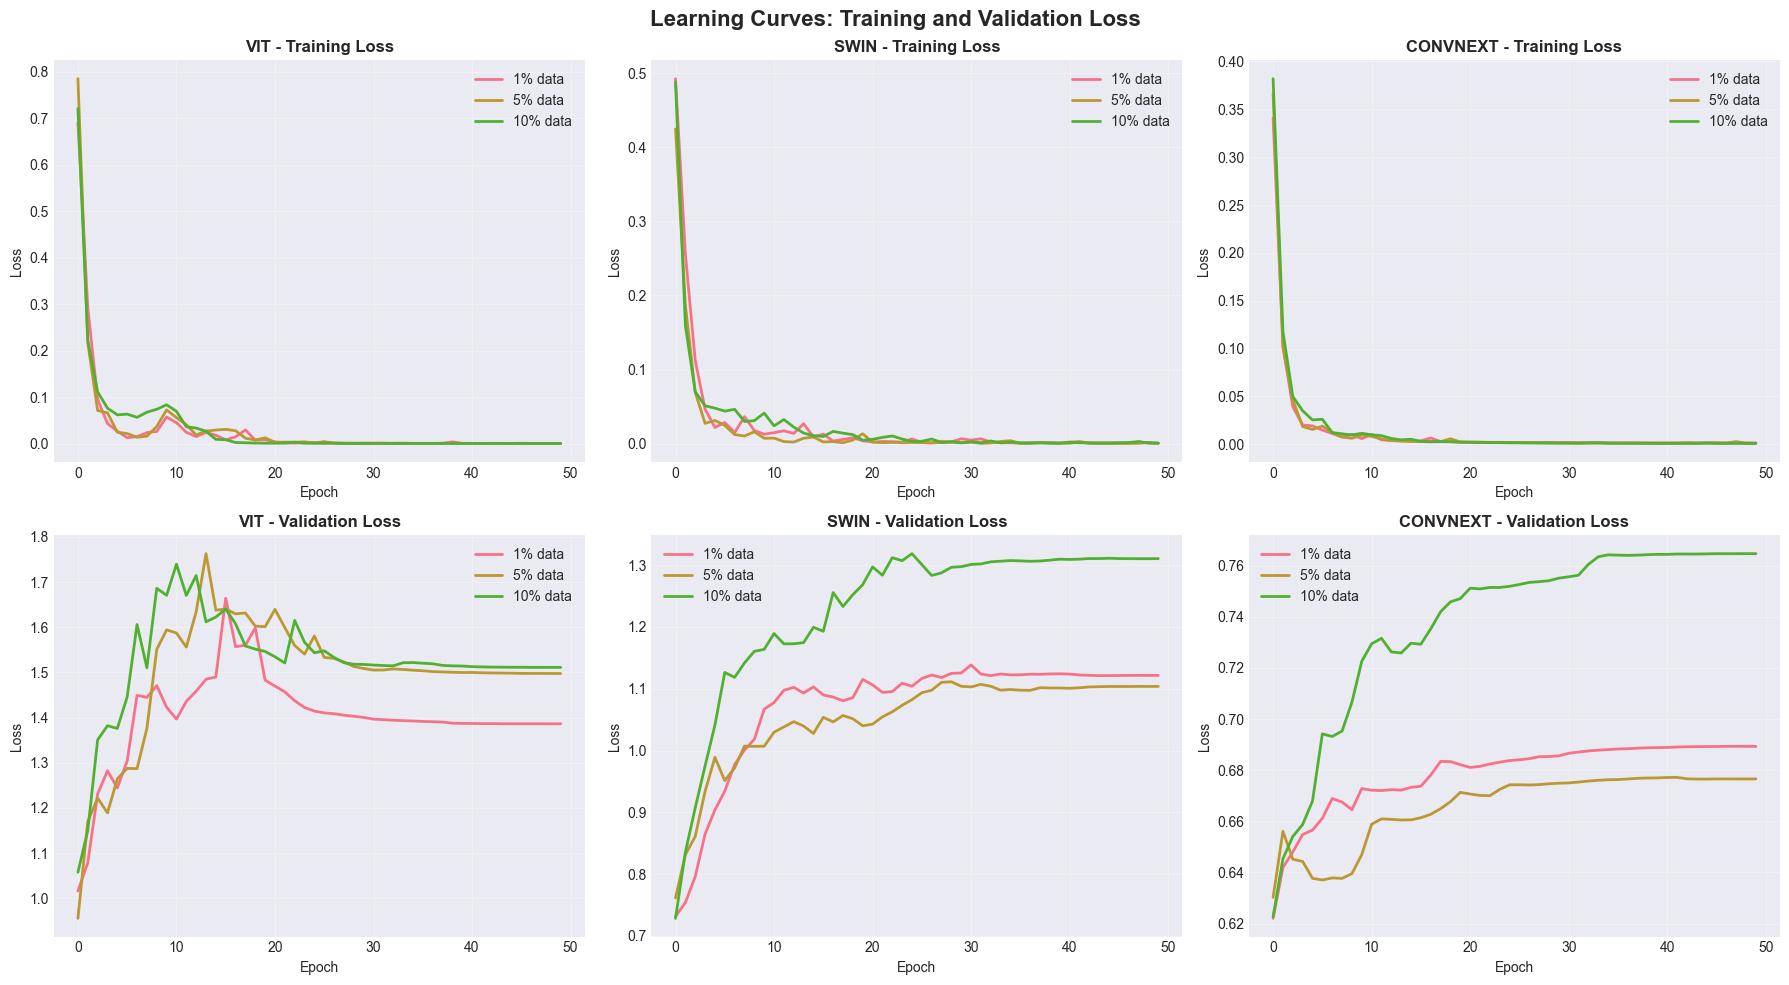

✓ Learning curves saved


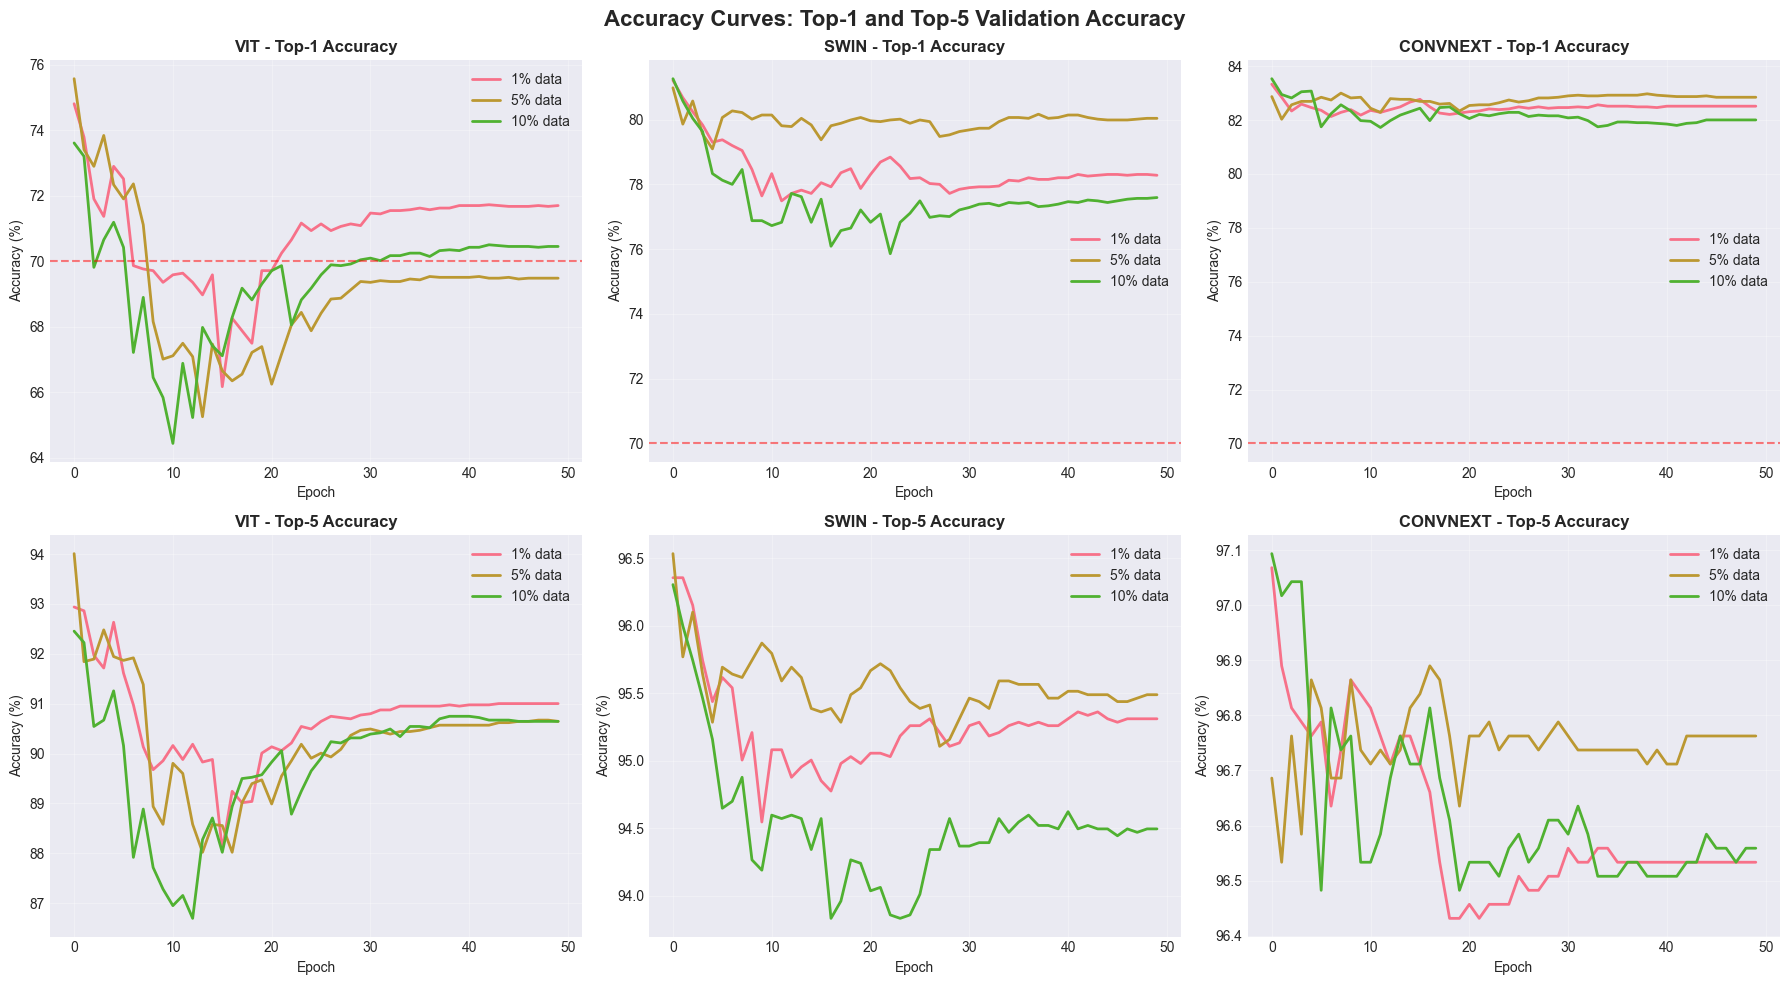

✓ Accuracy curves saved


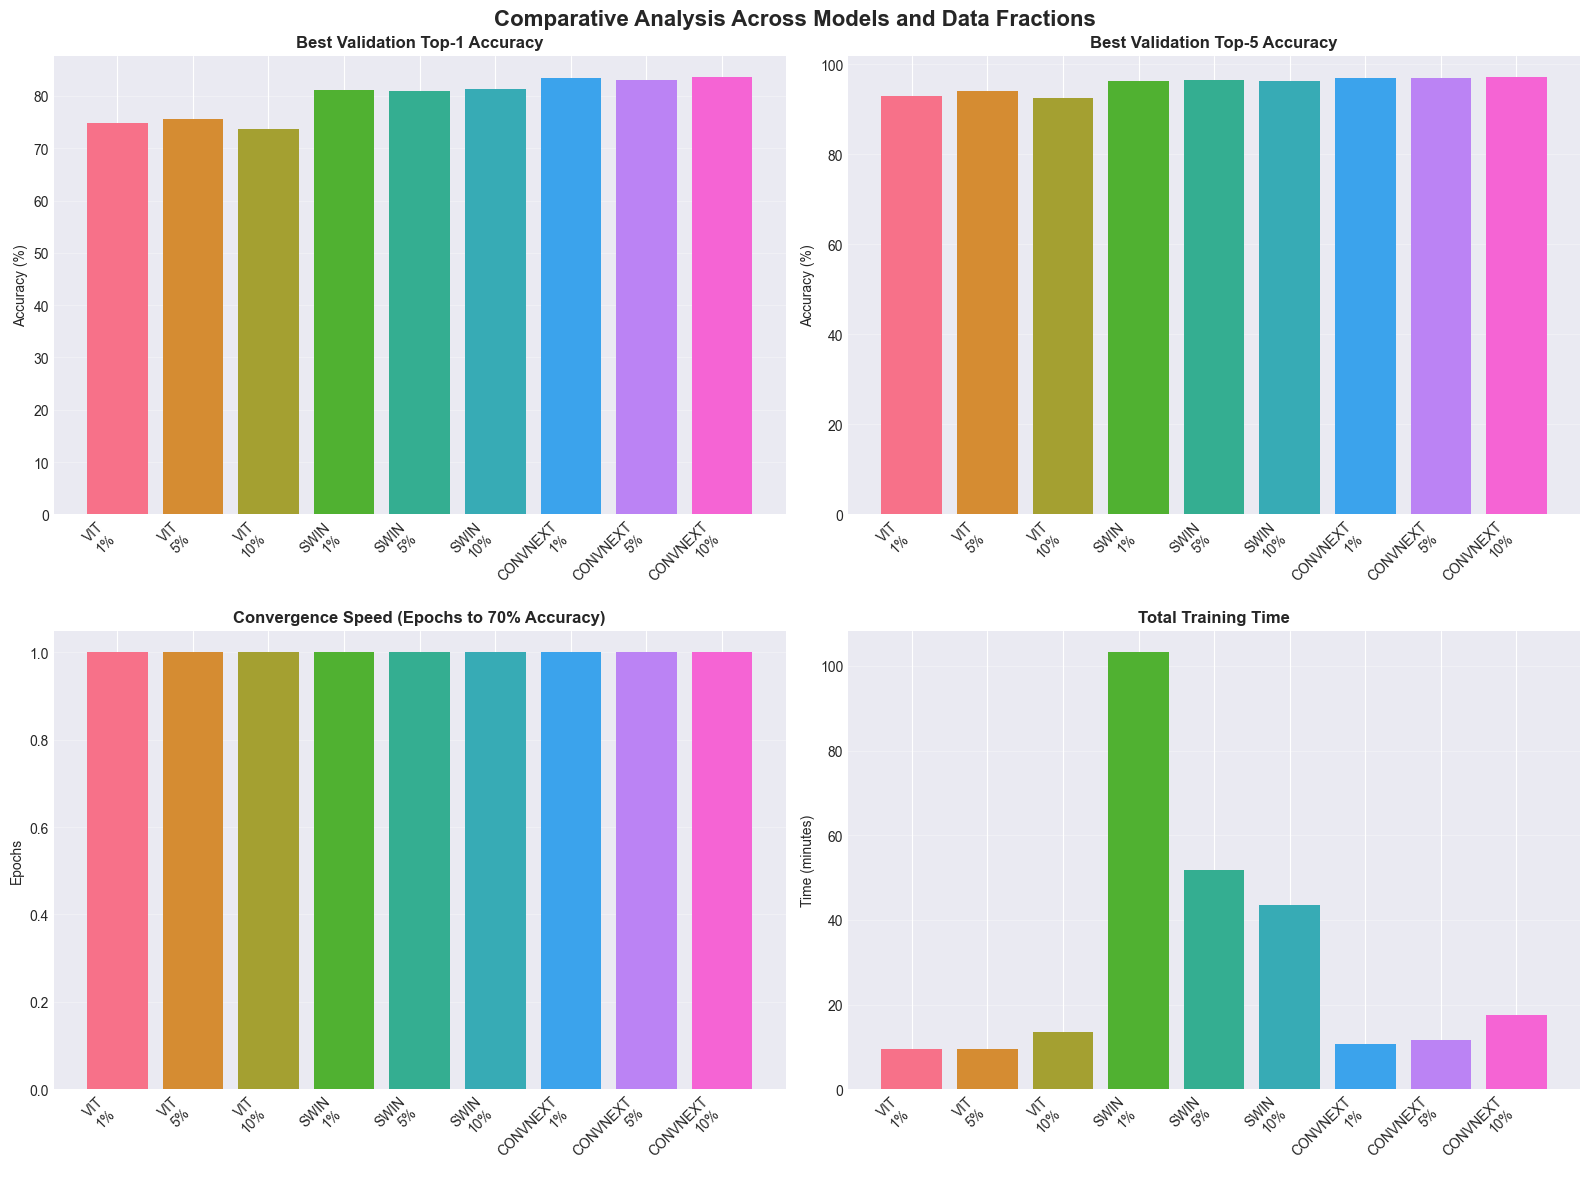

✓ Comparative analysis saved


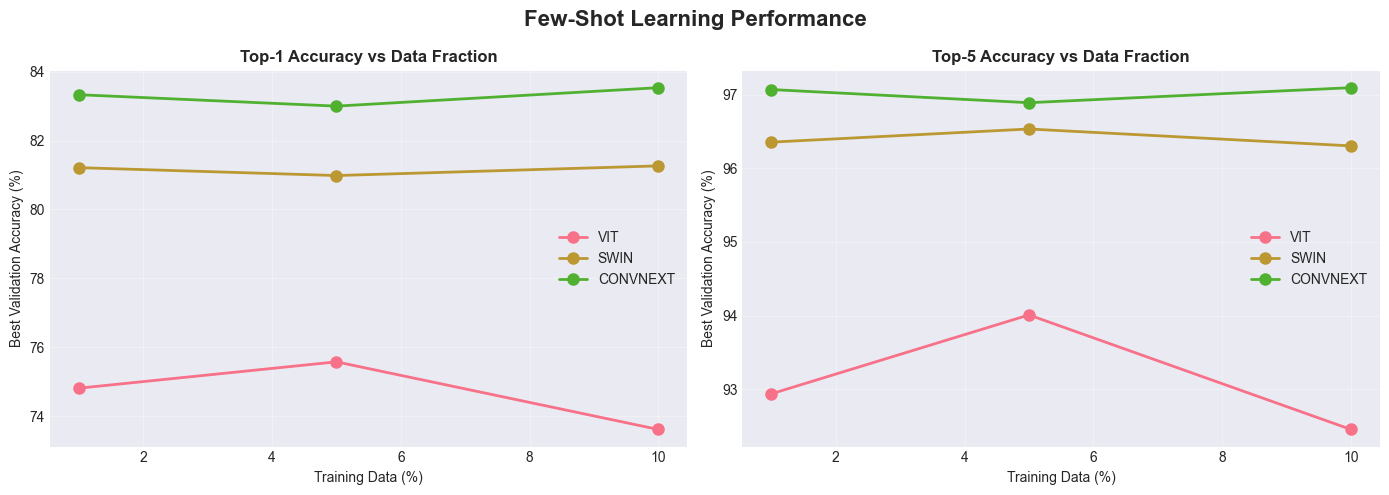

✓ Few-shot performance saved


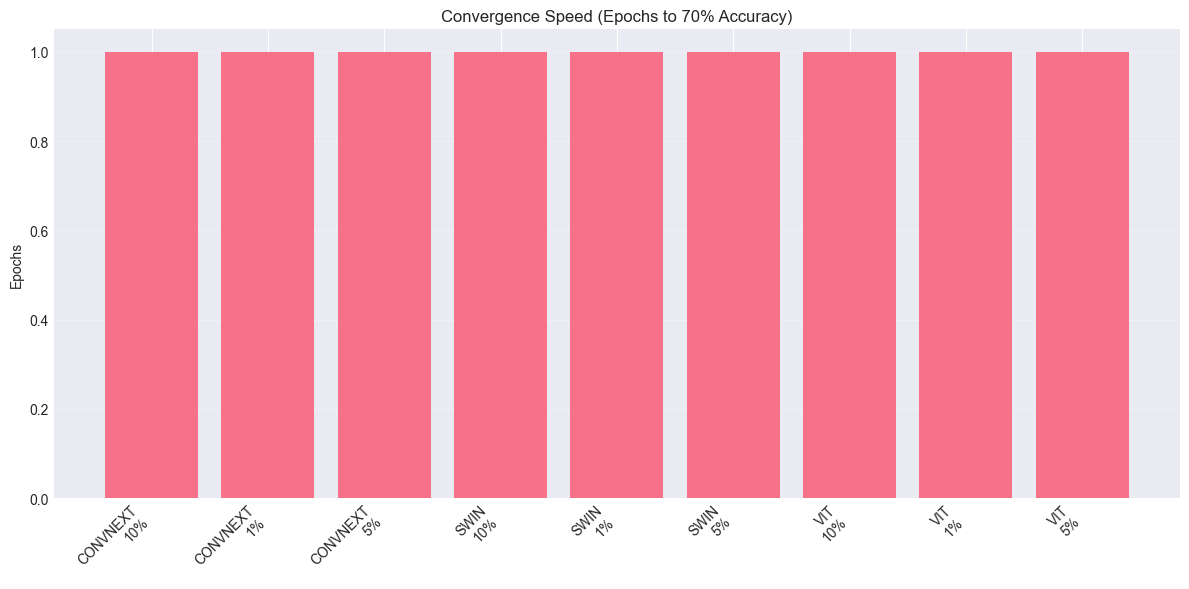

✓ Convergence speed saved


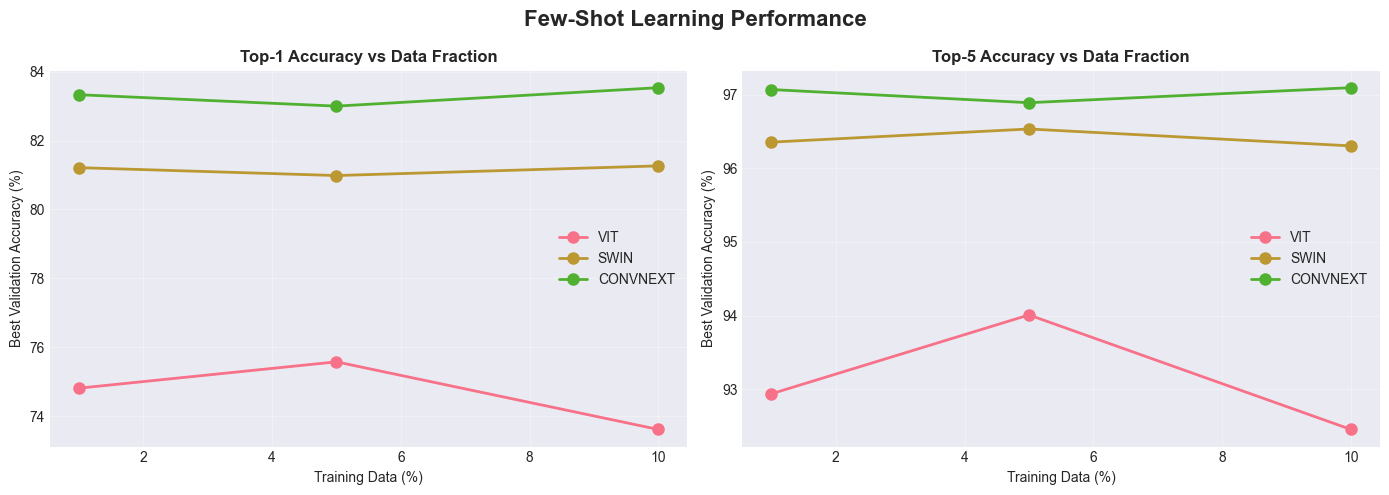

✓ Few-shot performance saved

All visualizations saved to results

EXPERIMENTAL RESULTS SUMMARY

   Model Data % Final Val Top-1 Final Val Top-5 Best Val Top-1  Convergence Epoch Training Time (min) Data Efficiency
     VIT     1%          71.71%          91.00%         74.82%                  1                9.55           74.82
     VIT     5%          69.49%          90.64%         75.58%                  1                9.62           15.12
     VIT    10%          70.46%          90.64%         73.62%                  1               13.57            7.36
    SWIN     1%          78.28%          95.31%         81.21%                  1              103.20           81.21
    SWIN     5%          80.04%          95.49%         80.98%                  1               51.83           16.20
    SWIN    10%          77.59%          94.49%         81.26%                  1               43.44            8.13
CONVNEXT     1%          82.51%          96.53%         83.33%               

In [11]:
# IMPORTANT: Choose one of the following execution modes:

# Option 1: Quick test (recommended first)
# Uncomment the line below to run a quick test with 3 epochs
# quick_test()

# Option 2: Full experimental pipeline
# Uncomment the line below to run all experiments
# WARNING: This will take several hours depending on your hardware
experiment_results = main()

# Option 3: Manual execution (for step-by-step control)
# Use the individual functions above to run specific experiments

print("\n" + "="*60)
print("NOTEBOOK READY")
print("="*60)
print("\nTo execute experiments:")
print("1. Update config.TRAIN_DIR and config.VAL_DIR with your dataset paths")
print("2. Run quick_test() to verify everything works")
print("3. Run main() to execute full experimental pipeline")
print("4. Results will be saved in ./results/ directory")
print("\n" + "="*60)